In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [8, 8]
sns.set_theme(style="whitegrid")
sns.color_palette("rocket", as_cmap=True)
sns.set_palette("pastel")
#hide all warnings
import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import pairwise_distances
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer

np.random.seed(44)

In [2]:
reviews = pd.read_csv("reviews.csv")
reviews.drop("Unnamed: 0", inplace=True, axis=1)

In [3]:
reviews["game_name"]=reviews.game_name.str.split("       ",expand=True,)[0]
reviews.head()

,game_id,game_name,score,author,date,summary
0,0,Disco Elysium: The Final Cut,100,GameGrin,"Oct 15, 2021",Traversing the mind of your character is as mu...
1,0,Disco Elysium: The Final Cut,100,Shindig,"Jun 18, 2021",Disco Elysium – The Final Cut is something rar...
2,0,Disco Elysium: The Final Cut,100,KeenGamer,"Apr 26, 2021","Enhanced with fantastic and fresh content, Dis..."
3,0,Disco Elysium: The Final Cut,100,GameSpot,"Apr 15, 2021",A fully voiced cast and new content of compara...
4,0,Disco Elysium: The Final Cut,100,Wccftech,"Apr 15, 2021",Disco Elysium: The Final Cut doesn't shy away ...


In [4]:
stop_words=set(stopwords.words("english"))

#tokenised list of reviews that do not contain stop words
def tokenized_summary(x):
    filtered_sent=[]
    for w in word_tokenize(x):
        if w not in stop_words:
            filtered_sent.append(w)
    return filtered_sent

reviews["tokenised"] = reviews['summary'].apply(lambda x: tokenized_summary(x))

In [5]:
#Lemmatization 
import string
lem = WordNetLemmatizer()
def lemmatized_list(x):
    lemmatized=[]
    for w in x:
        lemmatized.append(lem.lemmatize(w))
    final_string =  " ".join(lemmatized)
    return final_string.translate(str.maketrans('', '', string.punctuation))


reviews["lemmatized"] = reviews['tokenised'].apply(lambda x: lemmatized_list(x))


In [6]:
reviews.head()

,game_id,game_name,score,author,date,summary,tokenised,lemmatized
0,0,Disco Elysium: The Final Cut,100,GameGrin,"Oct 15, 2021",Traversing the mind of your character is as mu...,"[Traversing, mind, character, much, plot, case...",Traversing mind character much plot case ’ try...
1,0,Disco Elysium: The Final Cut,100,Shindig,"Jun 18, 2021",Disco Elysium – The Final Cut is something rar...,"[Disco, Elysium, –, The, Final, Cut, something...",Disco Elysium – The Final Cut something rare ...
2,0,Disco Elysium: The Final Cut,100,KeenGamer,"Apr 26, 2021","Enhanced with fantastic and fresh content, Dis...","[Enhanced, fantastic, fresh, content, ,, Disco...",Enhanced fantastic fresh content Disco Elysiu...
3,0,Disco Elysium: The Final Cut,100,GameSpot,"Apr 15, 2021",A fully voiced cast and new content of compara...,"[A, fully, voiced, cast, new, content, compara...",A fully voiced cast new content comparable qua...
4,0,Disco Elysium: The Final Cut,100,Wccftech,"Apr 15, 2021",Disco Elysium: The Final Cut doesn't shy away ...,"[Disco, Elysium, :, The, Final, Cut, n't, shy,...",Disco Elysium The Final Cut nt shy away probl...


In [7]:
#!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sid_obj = SentimentIntensityAnalyzer()

def vader_sentiment(x):
    sentiment_dict = sid_obj.polarity_scores(x)
    if sentiment_dict['compound'] > 0.05:
        return pd.Series(['positive', sentiment_dict['compound']])
    elif sentiment_dict['compound'] <= -0.05:
        return pd.Series(['negative', sentiment_dict['compound']])
    else:
        return pd.Series(['neutral',sentiment_dict['compound']])

reviews[["sentiment_label", 'sentiment_value']] = reviews['summary'].apply(lambda x: vader_sentiment(x))

In [8]:
reviews.head()

,game_id,game_name,score,author,date,summary,tokenised,lemmatized,sentiment_label,sentiment_value
0,0,Disco Elysium: The Final Cut,100,GameGrin,"Oct 15, 2021",Traversing the mind of your character is as mu...,"[Traversing, mind, character, much, plot, case...",Traversing mind character much plot case ’ try...,negative,-0.2960
1,0,Disco Elysium: The Final Cut,100,Shindig,"Jun 18, 2021",Disco Elysium – The Final Cut is something rar...,"[Disco, Elysium, –, The, Final, Cut, something...",Disco Elysium – The Final Cut something rare ...,positive,0.9142
2,0,Disco Elysium: The Final Cut,100,KeenGamer,"Apr 26, 2021","Enhanced with fantastic and fresh content, Dis...","[Enhanced, fantastic, fresh, content, ,, Disco...",Enhanced fantastic fresh content Disco Elysiu...,positive,0.9423
3,0,Disco Elysium: The Final Cut,100,GameSpot,"Apr 15, 2021",A fully voiced cast and new content of compara...,"[A, fully, voiced, cast, new, content, compara...",A fully voiced cast new content comparable qua...,positive,0.8705
4,0,Disco Elysium: The Final Cut,100,Wccftech,"Apr 15, 2021",Disco Elysium: The Final Cut doesn't shy away ...,"[Disco, Elysium, :, The, Final, Cut, n't, shy,...",Disco Elysium The Final Cut nt shy away probl...,negative,-0.4731


# Count vectorizer to identify similarity

In [9]:
# reading a list of attributes
attributes=list(line.strip() for line in open('attributes - Copy.csv'))
attributes=" ".join(attributes)
attributes

'action narrative quality soundtrack strategy'

In [10]:
# modifying the structure of the attributes
tempDataFrame=pd.DataFrame({'Game_review':[attributes]})
tempDataFrame=tempDataFrame.transpose()

In [11]:
# combining the selected attributes with the lematized game reviews
description_list1=reviews['lemmatized']
frames = [tempDataFrame, description_list1]
result = pd.concat(frames)
result.columns = ['review']
result=result.reset_index()

In [12]:
result.head()

,index,review
0,Game_review,action narrative quality soundtrack strategy
1,0,Traversing mind character much plot case ’ try...
2,1,Disco Elysium – The Final Cut something rare ...
3,2,Enhanced fantastic fresh content Disco Elysiu...
4,3,A fully voiced cast new content comparable qua...


In [13]:
# applying count vectorizer to the game reviews column
vec_words = CountVectorizer(decode_error='ignore',tokenizer=word_tokenize,stop_words='english')
total_features_words = vec_words.fit_transform(result['review'])

In [14]:
# calculating similarity between game reviews using cosine similiarity
subset_sparse = sparse.csr_matrix(total_features_words)
total_features_review=subset_sparse
total_features_attr=subset_sparse[0,]
similarity=1-pairwise_distances(total_features_attr,total_features_review, metric='cosine')

In [15]:
# merging similarity values into the game reviews dataframe
similarity=pd.DataFrame(similarity)
similarity=similarity.transpose()
similarity.columns = ['similarity']
similarity=similarity.drop(similarity.index[[0]])
reviews_df=reviews.assign(similarity=similarity.values)

In [16]:
# filtering top 10 positive and similar game reviews
reviews_df=reviews_df.sort_values(by=["similarity"],ascending=False)
reviews_df_sim=reviews_df["sentiment_value"]>=0.8
reviews_df[reviews_df_sim].head(10)

,game_id,game_name,score,author,date,summary,tokenised,lemmatized,sentiment_label,sentiment_value,similarity
1650,83,Dreamscaper,82,The Games Machine,"Sep 2, 2021","In a crowded roguelike landscape, Dreamscaper ...","[In, crowded, roguelike, landscape, ,, Dreamsc...",In crowded roguelike landscape Dreamscaper tr...,positive,0.9236,0.282843
4081,225,Lake,70,Vandal,"Sep 6, 2021",Lake is a peaceful narrative adventure that in...,"[Lake, peaceful, narrative, adventure, interes...",Lake peaceful narrative adventure interestingl...,positive,0.8779,0.269680
785,36,Trials of Fire,90,TheSixthAxis,"Apr 6, 2021","Trials of Fire is uniquely entertaining, and i...","[Trials, Fire, uniquely, entertaining, ,, 's, ...",Trials Fire uniquely entertaining s absolute ...,positive,0.9631,0.212132
674,29,Unpacking,90,Everyeye.it,"Nov 5, 2021",Accompanied by wonderful pixel art and a sooth...,"[Accompanied, wonderful, pixel, art, soothing,...",Accompanied wonderful pixel art soothing sound...,positive,0.8225,0.200000
1334,68,Age of Empires IV,86,IGN Italia,"Oct 25, 2021",Age of Empires IV won't shake the videogame wo...,"[Age, Empires, IV, wo, n't, shake, videogame, ...",Age Empires IV wo nt shake videogame world muc...,positive,0.8320,0.195180
4046,223,Breathedge,75,Multiplayer.it,"Feb 26, 2021","Breathedge is an atypical survival, which trie...","[Breathedge, atypical, survival, ,, tries, sub...",Breathedge atypical survival try subnautica y...,positive,0.8911,0.190693
3763,202,Backbone,60,Shacknews,"Jun 29, 2021",I am disappointed by the mixed feelings I get ...,"[I, disappointed, mixed, feelings, I, get, Bac...",I disappointed mixed feeling I get Backbone I...,positive,0.9737,0.187867
458,19,Death's Door,95,BaziCenter,"Aug 8, 2021",Death's Door is a well crafted Action RPG that...,"[Death, 's, Door, well, crafted, Action, RPG, ...",Death s Door well crafted Action RPG respect a...,positive,0.8479,0.186501
3189,169,Severed Steel,80,ZTGD,"Oct 1, 2021",Severed Steel is a fantastic ride while it las...,"[Severed, Steel, fantastic, ride, last, ,, map...",Severed Steel fantastic ride last map editor ...,positive,0.8981,0.177705
1732,88,Scarlet Nexus,80,Wccftech,"Jun 23, 2021","With masterfully crafted action combat, charmi...","[With, masterfully, crafted, action, combat, ,...",With masterfully crafted action combat charmi...,positive,0.9454,0.176166


# TFIDF FOR SIMILARITY

In [17]:
# reading a list of attributes
attributes=list(line.strip() for line in open('attributes - Copy.csv'))
attributes=" ".join(attributes)
attributes

'action narrative quality soundtrack strategy'

In [18]:
# applying tfidf vectorizer to the game reviews column
vec_words = TfidfVectorizer(decode_error='ignore',tokenizer=word_tokenize,stop_words='english')
total_features_words = vec_words.fit_transform(result['review'])

In [19]:
# calculating similarity between game reviews using cosine similiarity
subset_sparse = sparse.csr_matrix(total_features_words)
total_features_review=subset_sparse
total_features_attr=subset_sparse[0,]
similarity=1-pairwise_distances(total_features_attr,total_features_review, metric='cosine')

In [20]:
# merging similarity values into the game reviews dataframe
similarity=pd.DataFrame(similarity)
similarity=similarity.transpose()
similarity.columns = ['similarity']
similarity=similarity.drop(similarity.index[[0]])
reviews_df=reviews.assign(similarity=similarity.values)

In [21]:
# filtering top 10 positive and similar game reviews
reviews_df=reviews_df.sort_values(by=["similarity"],ascending=False)
reviews_df_sim=reviews_df["sentiment_value"]>=0.8
reviews_df[reviews_df_sim].head(10)

,game_id,game_name,score,author,date,summary,tokenised,lemmatized,sentiment_label,sentiment_value,similarity
1650,83,Dreamscaper,82,The Games Machine,"Sep 2, 2021","In a crowded roguelike landscape, Dreamscaper ...","[In, crowded, roguelike, landscape, ,, Dreamsc...",In crowded roguelike landscape Dreamscaper tr...,positive,0.9236,0.202030
785,36,Trials of Fire,90,TheSixthAxis,"Apr 6, 2021","Trials of Fire is uniquely entertaining, and i...","[Trials, Fire, uniquely, entertaining, ,, 's, ...",Trials Fire uniquely entertaining s absolute ...,positive,0.9631,0.188594
4081,225,Lake,70,Vandal,"Sep 6, 2021",Lake is a peaceful narrative adventure that in...,"[Lake, peaceful, narrative, adventure, interes...",Lake peaceful narrative adventure interestingl...,positive,0.8779,0.180363
1334,68,Age of Empires IV,86,IGN Italia,"Oct 25, 2021",Age of Empires IV won't shake the videogame wo...,"[Age, Empires, IV, wo, n't, shake, videogame, ...",Age Empires IV wo nt shake videogame world muc...,positive,0.8320,0.177076
458,19,Death's Door,95,BaziCenter,"Aug 8, 2021",Death's Door is a well crafted Action RPG that...,"[Death, 's, Door, well, crafted, Action, RPG, ...",Death s Door well crafted Action RPG respect a...,positive,0.8479,0.150735
1732,88,Scarlet Nexus,80,Wccftech,"Jun 23, 2021","With masterfully crafted action combat, charmi...","[With, masterfully, crafted, action, combat, ,...",With masterfully crafted action combat charmi...,positive,0.9454,0.150691
4129,227,Last Stop,60,Screen Rant,"Jul 21, 2021","Overall, Last Stop is something of a mixed bag...","[Overall, ,, Last, Stop, something, mixed, bag...",Overall Last Stop something mixed bag At bes...,positive,0.9621,0.145608
3673,197,The Dark Pictures Anthology: House of Ashes,80,PC Gamer,"Oct 21, 2021","Great monsters, stunning locations and a quali...","[Great, monsters, ,, stunning, locations, qual...",Great monster stunning location quality myste...,positive,0.8979,0.143949
4985,283,Warhammer Age of Sigmar: Storm Ground,80,Checkpoint Gaming,"Jun 1, 2021",A great strategy title for fans of tactical tu...,"[A, great, strategy, title, fans, tactical, tu...",A great strategy title fan tactical turnbased ...,positive,0.8898,0.142249
5039,285,King's Bounty II,60,Checkpoint Gaming,"Aug 25, 2021",King’s Bounty II has all the ingredients of a ...,"[King, ’, Bounty, II, ingredients, great, stra...",King ’ Bounty II ingredient great strategy gam...,positive,0.9071,0.140262


# CLUSTERING

## Using Count Vectorizer with sum aggregation for clustering

In [22]:
# applying countvectorizer vectorizer to the lematized game reviews column
vec_words = CountVectorizer(decode_error='ignore',tokenizer=word_tokenize,stop_words='english',min_df=10, max_features=500)
vectors = vec_words.fit_transform(reviews['lemmatized'])

feature_names = vec_words.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
count = pd.DataFrame(denselist, columns=feature_names)

In [23]:
# looking at column names
column_names = count.columns
list(column_names)

['2',
 '2021',
 '2042',
 '3',
 '4',
 '5',
 '6',
 'ability',
 'able',
 'absolutely',
 'accessible',
 'action',
 'actually',
 'add',
 'addictive',
 'addition',
 'adventure',
 'aesthetic',
 'age',
 'ai',
 'amazing',
 'ambitious',
 'animation',
 'apart',
 'appeal',
 'approach',
 'area',
 'art',
 'artistic',
 'ascent',
 'aside',
 'aspect',
 'atmosphere',
 'attempt',
 'attention',
 'audience',
 'available',
 'away',
 'bad',
 'balance',
 'base',
 'battle',
 'battlefield',
 'beautiful',
 'best',
 'better',
 'big',
 'biomutant',
 'bit',
 'blend',
 'blood',
 'boring',
 'brilliant',
 'bring',
 'brings',
 'bug',
 'build',
 'building',
 'campaign',
 'card',
 'case',
 'cast',
 'certain',
 'certainly',
 'challenge',
 'challenging',
 'chance',
 'change',
 'chapter',
 'character',
 'charm',
 'charming',
 'chernobylite',
 'choice',
 'city',
 'classic',
 'clear',
 'clearly',
 'clever',
 'collection',
 'combat',
 'come',
 'coming',
 'compelling',
 'complete',
 'completely',
 'complex',
 'concept',
 'conte

In [24]:
# dropping the first 7 and last 6 columns as they are not words
count=count.iloc[:,7:-6]
list(count.columns)

['ability',
 'able',
 'absolutely',
 'accessible',
 'action',
 'actually',
 'add',
 'addictive',
 'addition',
 'adventure',
 'aesthetic',
 'age',
 'ai',
 'amazing',
 'ambitious',
 'animation',
 'apart',
 'appeal',
 'approach',
 'area',
 'art',
 'artistic',
 'ascent',
 'aside',
 'aspect',
 'atmosphere',
 'attempt',
 'attention',
 'audience',
 'available',
 'away',
 'bad',
 'balance',
 'base',
 'battle',
 'battlefield',
 'beautiful',
 'best',
 'better',
 'big',
 'biomutant',
 'bit',
 'blend',
 'blood',
 'boring',
 'brilliant',
 'bring',
 'brings',
 'bug',
 'build',
 'building',
 'campaign',
 'card',
 'case',
 'cast',
 'certain',
 'certainly',
 'challenge',
 'challenging',
 'chance',
 'change',
 'chapter',
 'character',
 'charm',
 'charming',
 'chernobylite',
 'choice',
 'city',
 'classic',
 'clear',
 'clearly',
 'clever',
 'collection',
 'combat',
 'come',
 'coming',
 'compelling',
 'complete',
 'completely',
 'complex',
 'concept',
 'content',
 'control',
 'cool',
 'coop',
 'core',
 'co

In [25]:
# joining the game reviews df with the count vectorized attributes
final_df = reviews.join(count)
final_df.head()

,game_id,game_name,score,author,date,summary,tokenised,lemmatized,sentiment_label,sentiment_value,...,welcome,wish,wo,wonderful,work,world,worth,worthy,writing,year
0,0,Disco Elysium: The Final Cut,100,GameGrin,"Oct 15, 2021",Traversing the mind of your character is as mu...,"[Traversing, mind, character, much, plot, case...",Traversing mind character much plot case ’ try...,negative,-0.2960,...,0,0,0,0,0,1,0,0,0,0
1,0,Disco Elysium: The Final Cut,100,Shindig,"Jun 18, 2021",Disco Elysium – The Final Cut is something rar...,"[Disco, Elysium, –, The, Final, Cut, something...",Disco Elysium – The Final Cut something rare ...,positive,0.9142,...,0,0,0,0,0,0,0,0,0,0
2,0,Disco Elysium: The Final Cut,100,KeenGamer,"Apr 26, 2021","Enhanced with fantastic and fresh content, Dis...","[Enhanced, fantastic, fresh, content, ,, Disco...",Enhanced fantastic fresh content Disco Elysiu...,positive,0.9423,...,0,0,0,0,0,0,0,0,0,0
3,0,Disco Elysium: The Final Cut,100,GameSpot,"Apr 15, 2021",A fully voiced cast and new content of compara...,"[A, fully, voiced, cast, new, content, compara...",A fully voiced cast new content comparable qua...,positive,0.8705,...,1,0,0,0,0,0,0,0,0,1
4,0,Disco Elysium: The Final Cut,100,Wccftech,"Apr 15, 2021",Disco Elysium: The Final Cut doesn't shy away ...,"[Disco, Elysium, :, The, Final, Cut, n't, shy,...",Disco Elysium The Final Cut nt shy away probl...,negative,-0.4731,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# getting a list of column names to select key attributes of the games
cols=list(final_df.columns)
dictionary={"colnames":cols}
df=pd.DataFrame(dictionary)
df.to_csv("columns.csv")

In [27]:
# only include relevant attributes for clustering
attributes = pd.read_csv("good attributes.csv")
attributes

,colnames
0,game_id
1,game_name
2,score
3,author
4,date
...,...
124,visuals
125,vr
126,war
127,weapon


In [28]:
# identifying list of columns to keep
tokeep=list(attributes.colnames)
tokeep

['game_id',
 'game_name',
 'score',
 'author',
 'date',
 'summary',
 'tokenised',
 'lemmatized',
 'sentiment_label',
 'sentiment_value',
 'action',
 'adventure',
 'aesthetic',
 'ai',
 'ambitious',
 'appeal',
 'art',
 'atmosphere',
 'attention',
 'balance',
 'battle',
 'battlefield',
 'beautiful',
 'brilliant',
 'build',
 'building',
 'campaign',
 'challenge',
 'challenging',
 'character',
 'charm',
 'charming',
 'classic',
 'combat',
 'compelling',
 'complex',
 'dark',
 'dead',
 'death',
 'design',
 'detail',
 'developer',
 'development',
 'dialogue',
 'difficult',
 'difficulty',
 'dungeon',
 'edge',
 'edition',
 'effect',
 'element',
 'elite',
 'enemy',
 'engaging',
 'entertaining',
 'environment',
 'evil',
 'experience',
 'exploration',
 'explore',
 'fantasy',
 'feature',
 'feel',
 'feeling',
 'fight',
 'football',
 'franchise',
 'fresh',
 'fun',
 'gameplay',
 'gorgeous',
 'graphic',
 'hero',
 'history',
 'hit',
 'hitman',
 'horror',
 'indie',
 'interactive',
 'journey',
 'mission',


In [29]:
# identifying current list of columns
cols=list(final_df.columns)
cols

['game_id',
 'game_name',
 'score',
 'author',
 'date',
 'summary',
 'tokenised',
 'lemmatized',
 'sentiment_label',
 'sentiment_value',
 'ability',
 'able',
 'absolutely',
 'accessible',
 'action',
 'actually',
 'add',
 'addictive',
 'addition',
 'adventure',
 'aesthetic',
 'age',
 'ai',
 'amazing',
 'ambitious',
 'animation',
 'apart',
 'appeal',
 'approach',
 'area',
 'art',
 'artistic',
 'ascent',
 'aside',
 'aspect',
 'atmosphere',
 'attempt',
 'attention',
 'audience',
 'available',
 'away',
 'bad',
 'balance',
 'base',
 'battle',
 'battlefield',
 'beautiful',
 'best',
 'better',
 'big',
 'biomutant',
 'bit',
 'blend',
 'blood',
 'boring',
 'brilliant',
 'bring',
 'brings',
 'bug',
 'build',
 'building',
 'campaign',
 'card',
 'case',
 'cast',
 'certain',
 'certainly',
 'challenge',
 'challenging',
 'chance',
 'change',
 'chapter',
 'character',
 'charm',
 'charming',
 'chernobylite',
 'choice',
 'city',
 'classic',
 'clear',
 'clearly',
 'clever',
 'collection',
 'combat',
 'com

In [30]:
# removing the column names that aren't part of the list of columns to keep
for i in cols:
    if i not in tokeep:
        final_df.drop(columns=[i], inplace=True)

In [31]:
final_df.columns # left with 128 columns

Index(['game_id', 'game_name', 'score', 'author', 'date', 'summary',
       'tokenised', 'lemmatized', 'sentiment_label', 'sentiment_value',
       ...
       'universe', 'update', 'variety', 'version', 'visual', 'visuals', 'vr',
       'war', 'weapon', 'writing'],
      dtype='object', length=128)

In [32]:
# creating 2 separate data frames for calculations

# df with just the attributes 
final_df2=final_df.drop(columns=["game_name","author","date","summary","tokenised","lemmatized","sentiment_label","score","sentiment_value"])

# df with just the metascore and sentiment value
final_df3=final_df[["game_id","score","sentiment_value"]]

In [33]:
# aggregate values of each attribute column by the sum for each video game
final_df4=final_df2.groupby("game_id").sum() 
final_df5=final_df3.groupby("game_id").mean() # getting the mean metascore and sentiment for each video game
final_df6 = final_df5.join(final_df4)
final_df6.head()

,score,sentiment_value,action,adventure,aesthetic,ai,ambitious,appeal,art,atmosphere,...,universe,update,variety,version,visual,visuals,vr,war,weapon,writing
game_id,,,,,,,,,,,,,,,,,,,,,
0,97.272727,0.531809,0,0,0,0,0,0,1,0,...,0,1,0,2,0,0,0,0,0,0
1,91.962963,0.790196,0,4,0,0,2,0,0,0,...,1,0,0,0,2,0,0,0,0,0
2,91.100000,0.777425,2,3,0,1,0,0,0,0,...,0,1,2,0,1,1,0,0,0,0
3,89.782609,0.737909,0,9,1,0,1,1,2,0,...,2,0,0,0,0,0,0,0,0,0
4,88.970588,0.745638,1,6,0,0,0,1,1,0,...,3,0,0,0,2,1,0,0,0,2


In [34]:
# applying cosine similiarty
from sklearn.metrics.pairwise import cosine_similarity
dist=1-cosine_similarity(final_df6)
dist

array([[-1.11022302e-15,  6.38990953e-02,  1.44253159e-02, ...,
         2.21056037e-02,  1.16496824e-02,  4.62972562e-02],
       [ 6.38990953e-02, -8.88178420e-16,  6.69230588e-02, ...,
         5.02413567e-02,  6.79074662e-02,  1.01331135e-01],
       [ 1.44253159e-02,  6.69230588e-02,  3.33066907e-16, ...,
         3.24634060e-02,  1.55494162e-02,  4.09718405e-02],
       ...,
       [ 2.21056037e-02,  5.02413567e-02,  3.24634060e-02, ...,
         0.00000000e+00,  2.69545246e-02,  6.27881940e-02],
       [ 1.16496824e-02,  6.79074662e-02,  1.55494162e-02, ...,
         2.69545246e-02,  0.00000000e+00,  4.96607388e-02],
       [ 4.62972562e-02,  1.01331135e-01,  4.09718405e-02, ...,
         6.27881940e-02,  4.96607388e-02,  0.00000000e+00]])

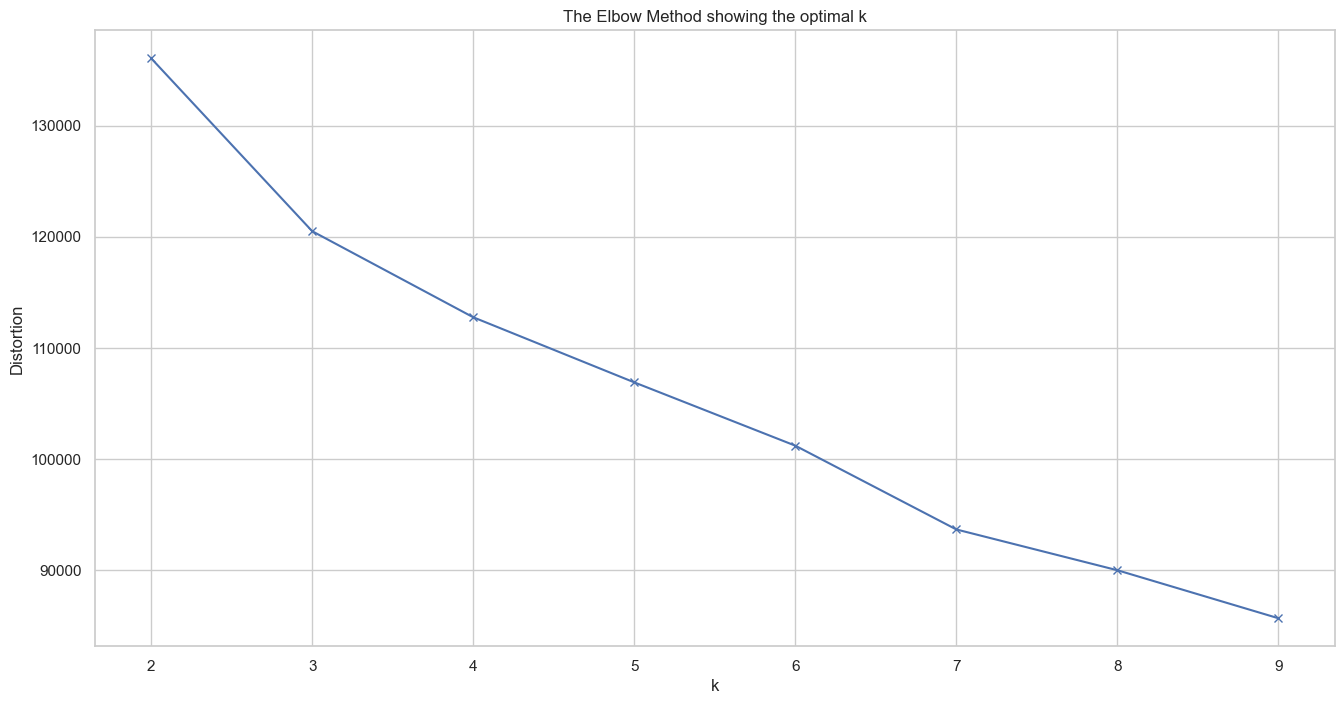

In [35]:
# using elbow method to determine number of clusters 
from sklearn.cluster import KMeans
vals = []
for i in range(2,10):
    kmeans=KMeans(n_clusters=i)
    model = kmeans.fit(final_df6)
    vals.append(model.inertia_)
K=range(2,10)
plt.figure(figsize=(16,8))
plt.plot(K, vals, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [36]:
# k-means clustering with 6 clusters
from sklearn.cluster import KMeans
num_clusters = 6
km = KMeans(n_clusters=num_clusters)
km.fit(final_df6)
clusters = km.labels_.tolist()

In [37]:
import joblib
joblib.dump(km,  'doc_cluster.pkl')

km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [38]:
# creating dataframe for clusters
dictionary={"clusters":clusters}
clusts=pd.DataFrame(dictionary)
clusts.head()

,clusters
0,4
1,3
2,4
3,4
4,4


In [39]:
# joining the clusters to the grouped file
games=final_df6.join(clusts)
games.head()

,score,sentiment_value,action,adventure,aesthetic,ai,ambitious,appeal,art,atmosphere,...,update,variety,version,visual,visuals,vr,war,weapon,writing,clusters
game_id,,,,,,,,,,,,,,,,,,,,,
0,97.272727,0.531809,0,0,0,0,0,0,1,0,...,1,0,2,0,0,0,0,0,0,4
1,91.962963,0.790196,0,4,0,0,2,0,0,0,...,0,0,0,2,0,0,0,0,0,3
2,91.100000,0.777425,2,3,0,1,0,0,0,0,...,1,2,0,1,1,0,0,0,0,4
3,89.782609,0.737909,0,9,1,0,1,1,2,0,...,0,0,0,0,0,0,0,0,0,4
4,88.970588,0.745638,1,6,0,0,0,1,1,0,...,0,0,0,2,1,0,0,0,2,4


In [40]:
# seeing how many games are in each cluster
games["clusters"].value_counts()

0    126
4    125
1     37
3     31
5      1
2      1
Name: clusters, dtype: int64

In [41]:
# average metascore per cluster
grouped=games["score"].groupby(games["clusters"])

grouped.mean()

clusters
0    71.304143
1    57.334808
2    67.972603
3    77.968482
4    81.250573
5    85.103448
Name: score, dtype: float64

In [42]:
# average sentiment per cluster
grouped=games["sentiment_value"].groupby(games["clusters"])

grouped.mean()

clusters
0    0.493021
1    0.297414
2    0.260697
3    0.566955
4    0.625008
5    0.778110
Name: sentiment_value, dtype: float64

In [43]:
# selecting only the attributes columns
attributes2=attributes.iloc[10:,:]
attributes2.colnames.tolist()

['action',
 'adventure',
 'aesthetic',
 'ai',
 'ambitious',
 'appeal',
 'art',
 'atmosphere',
 'attention',
 'balance',
 'battle',
 'battlefield',
 'beautiful',
 'brilliant',
 'build',
 'building',
 'campaign',
 'challenge',
 'challenging',
 'character',
 'charm',
 'charming',
 'classic',
 'combat',
 'compelling',
 'complex',
 'dark',
 'dead',
 'death',
 'design',
 'detail',
 'developer',
 'development',
 'dialogue',
 'difficult',
 'difficulty',
 'dungeon',
 'edge',
 'edition',
 'effect',
 'element',
 'elite',
 'enemy',
 'engaging',
 'entertaining',
 'environment',
 'evil',
 'experience',
 'exploration',
 'explore',
 'fantasy',
 'feature',
 'feel',
 'feeling',
 'fight',
 'football',
 'franchise',
 'fresh',
 'fun',
 'gameplay',
 'gorgeous',
 'graphic',
 'hero',
 'history',
 'hit',
 'hitman',
 'horror',
 'indie',
 'interactive',
 'journey',
 'mission',
 'monster',
 'multiplayer',
 'music',
 'mystery',
 'narrative',
 'pace',
 'pixel',
 'platforming',
 'presentation',
 'price',
 'puzzle',


In [44]:
# identifying the closest attributes to each cluster centroid
# code taken from : https://stackoverflow.com/questions/47452119/kmean-clustering-top-terms-in-cluster
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d:" % i, end='\n')
    for ind in order_centroids[i, :10]:
        print(' %s' % attributes2.colnames.tolist()[ind], end='')
        print()

Top terms per cluster:
Cluster 0:
 action
 exploration
 storytelling
 gameplay
 gorgeous
 feeling
 ai
 complex
 charming
 quality
Cluster 1:
 action
 exploration
 gameplay
 gorgeous
 enemy
 storytelling
 feeling
 complex
 developer
 war
Cluster 2:
 brilliant
 action
 shooter
 gameplay
 skill
 exploration
 gorgeous
 feeling
 music
 feel
Cluster 3:
 action
 storytelling
 exploration
 gorgeous
 complex
 feeling
 charming
 ai
 pace
 gameplay
Cluster 4:
 action
 exploration
 storytelling
 gorgeous
 gameplay
 feeling
 shooter
 complex
 charming
 ai
Cluster 5:
 action
 detail
 complex
 developer
 exploration
 ai
 aesthetic
 storytelling
 charm
 build


In [45]:
gamenames=list(final_df.game_name.unique())

In [46]:
# converting numpy array of similarity into dataframe
dist2=pd.DataFrame(dist)
dist2=dist2.set_axis([gamenames], axis=1)
dist2=dist2.set_axis([gamenames], axis="index")
dist2

,Disco Elysium: The Final Cut,Final Fantasy XIV: Endwalker,Forza Horizon 5,Chicory: A Colorful Tale,Psychonauts 2,Streets of Rage 4: Mr. X Nightmare,It Takes Two,Hitman 3,Wildermyth,Final Fantasy VII Remake Intergrade,...,Foreclosed,Buildings Have Feelings Too!,Dungeons & Dragons: Dark Alliance,AWAY: The Survival Series,Grand Theft Auto: The Trilogy - The Definitive Edition,Demon Skin,Arkham Horror: Mother's Embrace,Of Bird and Cage,Balan Wonderworld,eFootball 2022
Disco Elysium: The Final Cut,-1.110223e-15,6.389910e-02,1.442532e-02,2.649406e-02,2.550473e-02,0.011189,0.007225,0.293327,0.017952,0.020675,...,0.017204,0.013525,0.202769,0.022848,0.020991,1.208717e-02,1.814651e-02,0.022106,0.011650,0.046297
Final Fantasy XIV: Endwalker,6.389910e-02,-8.881784e-16,6.692306e-02,6.071536e-02,5.856850e-02,0.071462,0.061235,0.307841,0.037987,0.046628,...,0.060032,0.068794,0.230928,0.074389,0.081607,5.581002e-02,7.354189e-02,0.050241,0.067907,0.101331
Forza Horizon 5,1.442532e-02,6.692306e-02,3.330669e-16,2.918787e-02,2.458284e-02,0.021505,0.012762,0.280898,0.028910,0.026791,...,0.019528,0.020478,0.196657,0.014360,0.024650,1.847548e-02,2.435709e-02,0.032463,0.015549,0.040972
Chicory: A Colorful Tale,2.649406e-02,6.071536e-02,2.918787e-02,3.330669e-16,3.123897e-02,0.033282,0.018952,0.297969,0.031683,0.040839,...,0.024261,0.026739,0.209142,0.037130,0.042297,2.930198e-02,3.923371e-02,0.036356,0.027270,0.066459
Psychonauts 2,2.550473e-02,5.856850e-02,2.458284e-02,3.123897e-02,4.440892e-16,0.030835,0.021082,0.285729,0.029059,0.039185,...,0.023707,0.031732,0.199210,0.031865,0.043218,2.421615e-02,3.681485e-02,0.031296,0.025334,0.058209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Demon Skin,1.208717e-02,5.581002e-02,1.847548e-02,2.930198e-02,2.421615e-02,0.017787,0.011667,0.288939,0.017990,0.024976,...,0.018034,0.015583,0.184845,0.026593,0.025363,-2.220446e-16,2.049252e-02,0.023234,0.013522,0.048763
Arkham Horror: Mother's Embrace,1.814651e-02,7.354189e-02,2.435709e-02,3.923371e-02,3.681485e-02,0.025154,0.021138,0.299955,0.032453,0.031782,...,0.029007,0.024875,0.208239,0.033504,0.033752,2.049252e-02,-4.440892e-16,0.035233,0.024574,0.056062
Of Bird and Cage,2.210560e-02,5.024136e-02,3.246341e-02,3.635615e-02,3.129567e-02,0.029830,0.021461,0.289756,0.023214,0.038078,...,0.021787,0.028232,0.199911,0.039458,0.042586,2.323394e-02,3.523326e-02,0.000000,0.026955,0.062788
Balan Wonderworld,1.164968e-02,6.790747e-02,1.554942e-02,2.727023e-02,2.533395e-02,0.017084,0.011211,0.293360,0.023501,0.027994,...,0.023230,0.011166,0.202240,0.025924,0.025536,1.352222e-02,2.457413e-02,0.026955,0.000000,0.049661


In [47]:
# MDS plot for similarity
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist2) 
xs,ys = pos.T

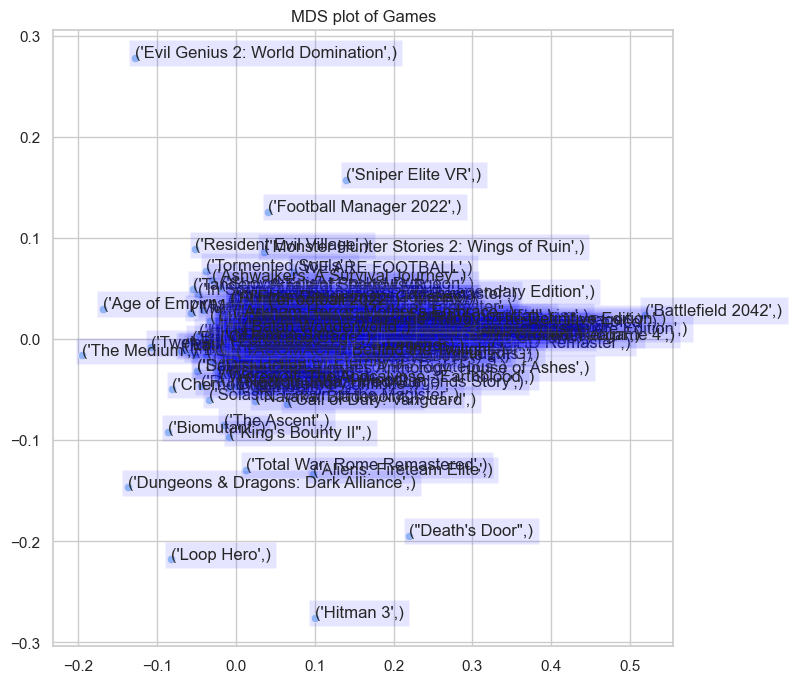

In [48]:
sns.scatterplot(xs,ys)
for i,game in enumerate(dist2.columns.values):
    plt.text(s=game, x= xs[i] , y=ys[i], bbox=dict(facecolor="blue",alpha=0.1))
plt.title('MDS plot of Games')
plt.savefig('MDSplot.png')
plt.show()

In [49]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e', 5:"#1e25a6"}

#set up cluster names using a dict
cluster_names = {0: 'C1', 
                 1: 'C2', 
                 2: 'C3', 
                 3: 'C4', 
                 4: 'C5',
                 5: "C6"}

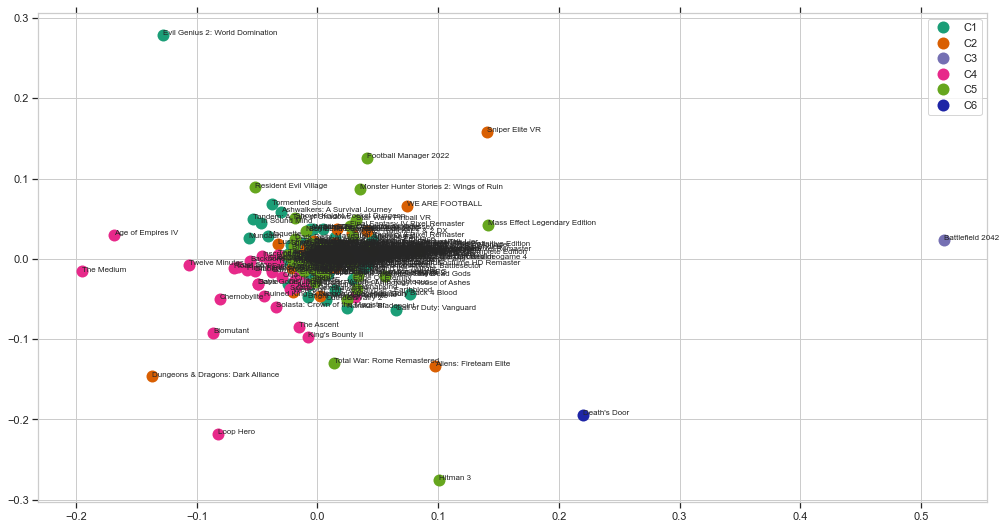

<Figure size 432x288 with 0 Axes>

In [50]:
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=gamenames)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the game title
for i in range(len(df)):
    ax.text(df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['title'], size=8)  

    
    
plt.show() #show the plot


plt.savefig('clusters_graph.png')

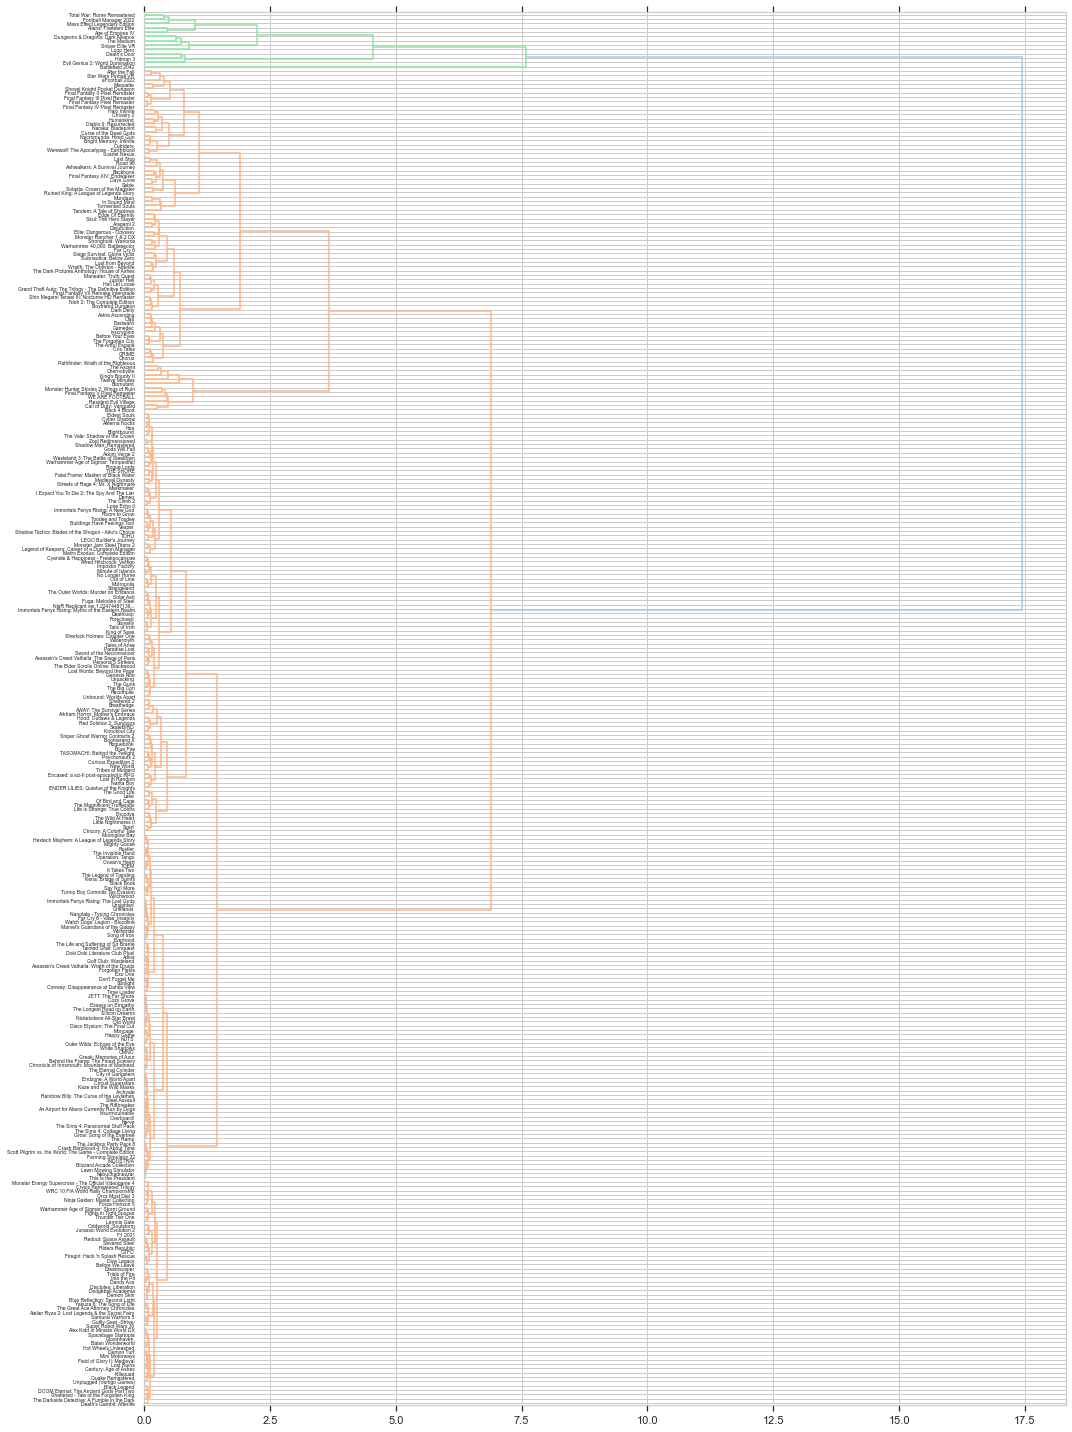

In [51]:
# Hierarchical document clustering
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist2) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=gamenames);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

## Using Count Vectorizer with mean aggregation for clustering

In [52]:
# applying countvectorizer vectorizer to the lematized game reviews column
vec_words = CountVectorizer(decode_error='ignore',tokenizer=word_tokenize,stop_words='english',min_df=10, max_features=500)
vectors = vec_words.fit_transform(reviews['lemmatized'])

feature_names = vec_words.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
count = pd.DataFrame(denselist, columns=feature_names)

In [53]:
# looking at column names
column_names = count.columns
list(column_names)

['2',
 '2021',
 '2042',
 '3',
 '4',
 '5',
 '6',
 'ability',
 'able',
 'absolutely',
 'accessible',
 'action',
 'actually',
 'add',
 'addictive',
 'addition',
 'adventure',
 'aesthetic',
 'age',
 'ai',
 'amazing',
 'ambitious',
 'animation',
 'apart',
 'appeal',
 'approach',
 'area',
 'art',
 'artistic',
 'ascent',
 'aside',
 'aspect',
 'atmosphere',
 'attempt',
 'attention',
 'audience',
 'available',
 'away',
 'bad',
 'balance',
 'base',
 'battle',
 'battlefield',
 'beautiful',
 'best',
 'better',
 'big',
 'biomutant',
 'bit',
 'blend',
 'blood',
 'boring',
 'brilliant',
 'bring',
 'brings',
 'bug',
 'build',
 'building',
 'campaign',
 'card',
 'case',
 'cast',
 'certain',
 'certainly',
 'challenge',
 'challenging',
 'chance',
 'change',
 'chapter',
 'character',
 'charm',
 'charming',
 'chernobylite',
 'choice',
 'city',
 'classic',
 'clear',
 'clearly',
 'clever',
 'collection',
 'combat',
 'come',
 'coming',
 'compelling',
 'complete',
 'completely',
 'complex',
 'concept',
 'conte

In [54]:
# dropping the first 7 and last 6 columns as they are not words
count=count.iloc[:,7:-6]
list(count.columns)

['ability',
 'able',
 'absolutely',
 'accessible',
 'action',
 'actually',
 'add',
 'addictive',
 'addition',
 'adventure',
 'aesthetic',
 'age',
 'ai',
 'amazing',
 'ambitious',
 'animation',
 'apart',
 'appeal',
 'approach',
 'area',
 'art',
 'artistic',
 'ascent',
 'aside',
 'aspect',
 'atmosphere',
 'attempt',
 'attention',
 'audience',
 'available',
 'away',
 'bad',
 'balance',
 'base',
 'battle',
 'battlefield',
 'beautiful',
 'best',
 'better',
 'big',
 'biomutant',
 'bit',
 'blend',
 'blood',
 'boring',
 'brilliant',
 'bring',
 'brings',
 'bug',
 'build',
 'building',
 'campaign',
 'card',
 'case',
 'cast',
 'certain',
 'certainly',
 'challenge',
 'challenging',
 'chance',
 'change',
 'chapter',
 'character',
 'charm',
 'charming',
 'chernobylite',
 'choice',
 'city',
 'classic',
 'clear',
 'clearly',
 'clever',
 'collection',
 'combat',
 'come',
 'coming',
 'compelling',
 'complete',
 'completely',
 'complex',
 'concept',
 'content',
 'control',
 'cool',
 'coop',
 'core',
 'co

In [55]:
# joining the game reviews df with the count vectorized attributes
final_df = reviews.join(count)
final_df.head()

,game_id,game_name,score,author,date,summary,tokenised,lemmatized,sentiment_label,sentiment_value,...,welcome,wish,wo,wonderful,work,world,worth,worthy,writing,year
0,0,Disco Elysium: The Final Cut,100,GameGrin,"Oct 15, 2021",Traversing the mind of your character is as mu...,"[Traversing, mind, character, much, plot, case...",Traversing mind character much plot case ’ try...,negative,-0.2960,...,0,0,0,0,0,1,0,0,0,0
1,0,Disco Elysium: The Final Cut,100,Shindig,"Jun 18, 2021",Disco Elysium – The Final Cut is something rar...,"[Disco, Elysium, –, The, Final, Cut, something...",Disco Elysium – The Final Cut something rare ...,positive,0.9142,...,0,0,0,0,0,0,0,0,0,0
2,0,Disco Elysium: The Final Cut,100,KeenGamer,"Apr 26, 2021","Enhanced with fantastic and fresh content, Dis...","[Enhanced, fantastic, fresh, content, ,, Disco...",Enhanced fantastic fresh content Disco Elysiu...,positive,0.9423,...,0,0,0,0,0,0,0,0,0,0
3,0,Disco Elysium: The Final Cut,100,GameSpot,"Apr 15, 2021",A fully voiced cast and new content of compara...,"[A, fully, voiced, cast, new, content, compara...",A fully voiced cast new content comparable qua...,positive,0.8705,...,1,0,0,0,0,0,0,0,0,1
4,0,Disco Elysium: The Final Cut,100,Wccftech,"Apr 15, 2021",Disco Elysium: The Final Cut doesn't shy away ...,"[Disco, Elysium, :, The, Final, Cut, n't, shy,...",Disco Elysium The Final Cut nt shy away probl...,negative,-0.4731,...,0,0,0,0,0,0,0,0,0,0


In [56]:
# getting a list of column names to select key attributes of the games
cols=list(final_df.columns)
dictionary={"colnames":cols}
df=pd.DataFrame(dictionary)
df.to_csv("columns.csv")

In [57]:
# only include relevant attributes for clustering
attributes = pd.read_csv("columns cleanv2 - Copy.csv")
attributes

,colnames
0,game_id
1,game_name
2,score
3,author
4,date
...,...
124,visuals
125,vr
126,war
127,weapon


In [58]:
# identifying list of columns to keep
tokeep=list(attributes.colnames)
tokeep

['game_id',
 'game_name',
 'score',
 'author',
 'date',
 'summary',
 'tokenised',
 'lemmatized',
 'sentiment_label',
 'sentiment_value',
 'action',
 'adventure',
 'aesthetic',
 'ai',
 'ambitious',
 'appeal',
 'art',
 'atmosphere',
 'attention',
 'balance',
 'battle',
 'battlefield',
 'beautiful',
 'brilliant',
 'build',
 'building',
 'campaign',
 'challenge',
 'challenging',
 'character',
 'charm',
 'charming',
 'classic',
 'combat',
 'compelling',
 'complex',
 'dark',
 'dead',
 'death',
 'design',
 'detail',
 'developer',
 'development',
 'dialogue',
 'difficult',
 'difficulty',
 'dungeon',
 'edge',
 'edition',
 'effect',
 'element',
 'elite',
 'enemy',
 'engaging',
 'entertaining',
 'environment',
 'evil',
 'experience',
 'exploration',
 'explore',
 'fantasy',
 'feature',
 'feel',
 'feeling',
 'fight',
 'football',
 'franchise',
 'fresh',
 'fun',
 'gameplay',
 'gorgeous',
 'graphic',
 'hero',
 'history',
 'hit',
 'hitman',
 'horror',
 'indie',
 'interactive',
 'journey',
 'mission',


In [59]:
# identifying current list of columns
cols=list(final_df.columns)
cols

['game_id',
 'game_name',
 'score',
 'author',
 'date',
 'summary',
 'tokenised',
 'lemmatized',
 'sentiment_label',
 'sentiment_value',
 'ability',
 'able',
 'absolutely',
 'accessible',
 'action',
 'actually',
 'add',
 'addictive',
 'addition',
 'adventure',
 'aesthetic',
 'age',
 'ai',
 'amazing',
 'ambitious',
 'animation',
 'apart',
 'appeal',
 'approach',
 'area',
 'art',
 'artistic',
 'ascent',
 'aside',
 'aspect',
 'atmosphere',
 'attempt',
 'attention',
 'audience',
 'available',
 'away',
 'bad',
 'balance',
 'base',
 'battle',
 'battlefield',
 'beautiful',
 'best',
 'better',
 'big',
 'biomutant',
 'bit',
 'blend',
 'blood',
 'boring',
 'brilliant',
 'bring',
 'brings',
 'bug',
 'build',
 'building',
 'campaign',
 'card',
 'case',
 'cast',
 'certain',
 'certainly',
 'challenge',
 'challenging',
 'chance',
 'change',
 'chapter',
 'character',
 'charm',
 'charming',
 'chernobylite',
 'choice',
 'city',
 'classic',
 'clear',
 'clearly',
 'clever',
 'collection',
 'combat',
 'com

In [60]:
# removing the column names that aren't part of the list of columns to keep
for i in cols:
    if i not in tokeep:
        final_df.drop(columns=[i], inplace=True)

In [61]:
final_df.columns

Index(['game_id', 'game_name', 'score', 'author', 'date', 'summary',
       'tokenised', 'lemmatized', 'sentiment_label', 'sentiment_value',
       ...
       'universe', 'update', 'variety', 'version', 'visual', 'visuals', 'vr',
       'war', 'weapon', 'writing'],
      dtype='object', length=128)

In [62]:
# creating 2 separate data frames for calculations

# df with just the attributes 
final_df2=final_df.drop(columns=["game_name","author","date","summary","tokenised","lemmatized","sentiment_label","score","sentiment_value"])

# df with just the metascore and sentiment value
final_df3=final_df[["game_id","score","sentiment_value"]]

In [63]:
# aggregate values of each attribute column by the mean for each video game
final_df4=final_df2.groupby("game_id").mean() 
final_df5=final_df3.groupby("game_id").mean()
final_df6 = final_df5.join(final_df4)
final_df6.head()

,score,sentiment_value,action,adventure,aesthetic,ai,ambitious,appeal,art,atmosphere,...,universe,update,variety,version,visual,visuals,vr,war,weapon,writing
game_id,,,,,,,,,,,,,,,,,,,,,
0,97.272727,0.531809,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.090909,0.0,...,0.000000,0.090909,0.0,0.181818,0.000000,0.000000,0.0,0.0,0.0,0.000000
1,91.962963,0.790196,0.000000,0.148148,0.000000,0.00,0.074074,0.000000,0.000000,0.0,...,0.037037,0.000000,0.0,0.000000,0.074074,0.000000,0.0,0.0,0.0,0.000000
2,91.100000,0.777425,0.100000,0.150000,0.000000,0.05,0.000000,0.000000,0.000000,0.0,...,0.000000,0.050000,0.1,0.000000,0.050000,0.050000,0.0,0.0,0.0,0.000000
3,89.782609,0.737909,0.000000,0.391304,0.043478,0.00,0.043478,0.043478,0.086957,0.0,...,0.086957,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
4,88.970588,0.745638,0.029412,0.176471,0.000000,0.00,0.000000,0.029412,0.029412,0.0,...,0.088235,0.000000,0.0,0.000000,0.058824,0.029412,0.0,0.0,0.0,0.058824


In [64]:
# applying cosine similiarty
from sklearn.metrics.pairwise import cosine_similarity
dist=1-cosine_similarity(final_df6)
dist

array([[-1.55431223e-15,  1.19512780e-04,  6.58940995e-05, ...,
         1.39427080e-04,  9.78833747e-05,  1.03020961e-03],
       [ 1.19512780e-04, -2.22044605e-15,  1.09606410e-04, ...,
         1.34625572e-04,  1.52040248e-04,  1.12193043e-03],
       [ 6.58940995e-05,  1.09606410e-04,  1.11022302e-15, ...,
         1.71726935e-04,  8.54322970e-05,  9.83541507e-04],
       ...,
       [ 1.39427080e-04,  1.34625572e-04,  1.71726935e-04, ...,
         4.44089210e-16,  1.79953093e-04,  1.12776236e-03],
       [ 9.78833747e-05,  1.52040248e-04,  8.54322970e-05, ...,
         1.79953093e-04, -4.44089210e-16,  1.05352221e-03],
       [ 1.03020961e-03,  1.12193043e-03,  9.83541507e-04, ...,
         1.12776236e-03,  1.05352221e-03, -2.22044605e-16]])

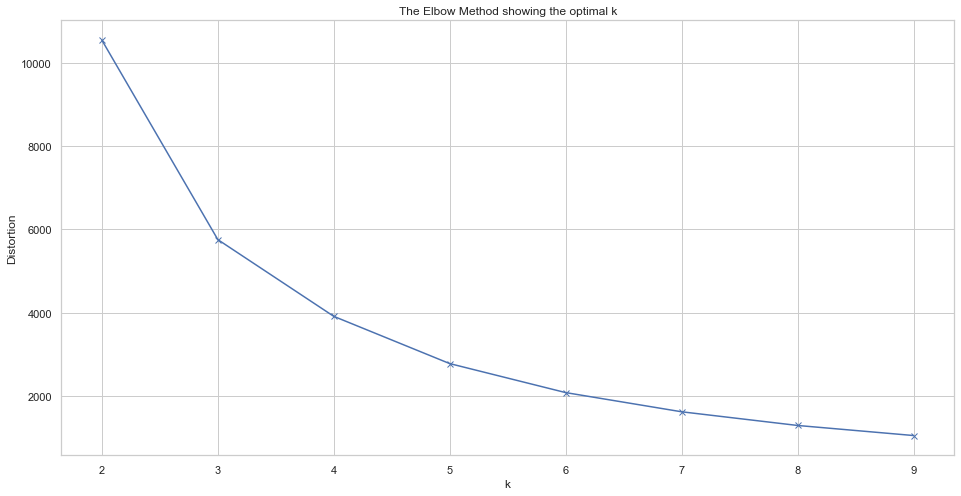

In [65]:
# using elbow method to determine number of clusters 
from sklearn.cluster import KMeans
vals = []
for i in range(2,10):
    kmeans=KMeans(n_clusters=i)
    model = kmeans.fit(final_df6)
    vals.append(model.inertia_)
K=range(2,10)
plt.figure(figsize=(16,8))
plt.plot(K, vals, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [66]:
# k-means clustering with 6 clusters
from sklearn.cluster import KMeans
num_clusters = 6
km = KMeans(n_clusters=num_clusters)
km.fit(final_df6)
clusters = km.labels_.tolist()

In [67]:
import joblib
joblib.dump(km,  'doc_cluster.pkl')

km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [68]:
# creating dataframe for clusters
dictionary={"clusters":clusters}
clusts=pd.DataFrame(dictionary)
clusts

,clusters
0,2
1,2
2,2
3,2
4,2
...,...
316,1
317,1
318,1
319,1


In [69]:
# joining the clusters to the grouped file
games=final_df6.join(clusts)
games

,score,sentiment_value,action,adventure,aesthetic,ai,ambitious,appeal,art,atmosphere,...,update,variety,version,visual,visuals,vr,war,weapon,writing,clusters
game_id,,,,,,,,,,,,,,,,,,,,,
0,97.272727,0.531809,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.090909,0.000000,...,0.090909,0.0,0.181818,0.000000,0.000000,0.0,0.0,0.0,0.000000,2
1,91.962963,0.790196,0.000000,0.148148,0.000000,0.00,0.074074,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.074074,0.000000,0.0,0.0,0.0,0.000000,2
2,91.100000,0.777425,0.100000,0.150000,0.000000,0.05,0.000000,0.000000,0.000000,0.000000,...,0.050000,0.1,0.000000,0.050000,0.050000,0.0,0.0,0.0,0.000000,2
3,89.782609,0.737909,0.000000,0.391304,0.043478,0.00,0.043478,0.043478,0.086957,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,2
4,88.970588,0.745638,0.029412,0.176471,0.000000,0.00,0.000000,0.029412,0.029412,0.000000,...,0.000000,0.0,0.000000,0.058824,0.029412,0.0,0.0,0.0,0.058824,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,48.800000,0.250970,0.000000,0.000000,0.000000,0.10,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,1
317,48.428571,-0.250000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.142857,...,0.000000,0.0,0.142857,0.000000,0.000000,0.0,0.0,0.0,0.000000,1
318,43.846154,0.304862,0.000000,0.000000,0.000000,0.00,0.076923,0.076923,0.000000,0.000000,...,0.000000,0.0,0.000000,0.076923,0.076923,0.0,0.0,0.0,0.076923,1


In [70]:
# seeing how many games are in each cluster
games["clusters"].value_counts()

4    93
0    81
2    59
3    56
5    26
1     6
Name: clusters, dtype: int64

In [71]:
# average metascore per cluster
grouped=games["score"].groupby(games["clusters"])

grouped.mean()

clusters
0    73.265849
1    42.383666
2    84.661867
3    67.523348
4    78.838648
5    59.036255
Name: score, dtype: float64

In [72]:
# average sentiment per cluster
grouped=games["sentiment_value"].groupby(games["clusters"])

grouped.mean()

clusters
0    0.502515
1    0.067719
2    0.644532
3    0.462283
4    0.599499
5    0.349492
Name: sentiment_value, dtype: float64

In [73]:
# selecting only the attributes columns
attributes2=attributes.iloc[10:,:]
attributes2.colnames.tolist()

['action',
 'adventure',
 'aesthetic',
 'ai',
 'ambitious',
 'appeal',
 'art',
 'atmosphere',
 'attention',
 'balance',
 'battle',
 'battlefield',
 'beautiful',
 'brilliant',
 'build',
 'building',
 'campaign',
 'challenge',
 'challenging',
 'character',
 'charm',
 'charming',
 'classic',
 'combat',
 'compelling',
 'complex',
 'dark',
 'dead',
 'death',
 'design',
 'detail',
 'developer',
 'development',
 'dialogue',
 'difficult',
 'difficulty',
 'dungeon',
 'edge',
 'edition',
 'effect',
 'element',
 'elite',
 'enemy',
 'engaging',
 'entertaining',
 'environment',
 'evil',
 'experience',
 'exploration',
 'explore',
 'fantasy',
 'feature',
 'feel',
 'feeling',
 'fight',
 'football',
 'franchise',
 'fresh',
 'fun',
 'gameplay',
 'gorgeous',
 'graphic',
 'hero',
 'history',
 'hit',
 'hitman',
 'horror',
 'indie',
 'interactive',
 'journey',
 'mission',
 'monster',
 'multiplayer',
 'music',
 'mystery',
 'narrative',
 'pace',
 'pixel',
 'platforming',
 'presentation',
 'price',
 'puzzle',


In [74]:
# identifying the closest attributes to each cluster centroid
# code taken from : https://stackoverflow.com/questions/47452119/kmean-clustering-top-terms-in-cluster
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d:" % i, end='\n')
    for ind in order_centroids[i, :10]:
        print(' %s' % attributes2.colnames.tolist()[ind], end='')
        print()

Top terms per cluster:
Cluster 0:
 action
 adventure
 exploration
 storytelling
 gorgeous
 gameplay
 feeling
 ai
 charming
 complex
Cluster 1:
 action
 indie
 twist
 franchise
 storytelling
 gorgeous
 exploration
 shooter
 feeling
 complex
Cluster 2:
 action
 adventure
 storytelling
 exploration
 gorgeous
 shooter
 ai
 gameplay
 charming
 complex
Cluster 3:
 action
 adventure
 exploration
 gameplay
 storytelling
 gorgeous
 feeling
 ai
 complex
 charming
Cluster 4:
 action
 adventure
 exploration
 storytelling
 gameplay
 feeling
 gorgeous
 complex
 charming
 ai
Cluster 5:
 action
 adventure
 exploration
 gorgeous
 storytelling
 multiplayer
 gameplay
 feeling
 complex
 ai


In [75]:
gamenames=list(final_df.game_name.unique())

In [76]:
# converting numpy array of similarity into dataframe
dist2=pd.DataFrame(dist)
dist2=dist2.set_axis([gamenames], axis=1)
dist2=dist2.set_axis([gamenames], axis="index")
dist2

,Disco Elysium: The Final Cut,Final Fantasy XIV: Endwalker,Forza Horizon 5,Chicory: A Colorful Tale,Psychonauts 2,Streets of Rage 4: Mr. X Nightmare,It Takes Two,Hitman 3,Wildermyth,Final Fantasy VII Remake Intergrade,...,Foreclosed,Buildings Have Feelings Too!,Dungeons & Dragons: Dark Alliance,AWAY: The Survival Series,Grand Theft Auto: The Trilogy - The Definitive Edition,Demon Skin,Arkham Horror: Mother's Embrace,Of Bird and Cage,Balan Wonderworld,eFootball 2022
Disco Elysium: The Final Cut,-1.554312e-15,1.195128e-04,6.589410e-05,7.663973e-05,5.020086e-05,0.000095,0.000043,0.000188,0.000056,0.000081,...,0.000150,0.000157,0.000234,0.000452,0.000322,1.150720e-04,4.030194e-04,1.394271e-04,9.788337e-05,1.030210e-03
Final Fantasy XIV: Endwalker,1.195128e-04,-2.220446e-15,1.096064e-04,9.945030e-05,8.600226e-05,0.000179,0.000096,0.000224,0.000058,0.000082,...,0.000187,0.000197,0.000301,0.000483,0.000417,1.159350e-04,4.960297e-04,1.346256e-04,1.520402e-04,1.121930e-03
Forza Horizon 5,6.589410e-05,1.096064e-04,1.110223e-15,6.221986e-05,3.220790e-05,0.000123,0.000034,0.000157,0.000070,0.000084,...,0.000155,0.000153,0.000232,0.000348,0.000324,1.129381e-04,4.480583e-04,1.717269e-04,8.543230e-05,9.835415e-04
Chicory: A Colorful Tale,7.663973e-05,9.945030e-05,6.221986e-05,-2.220446e-16,4.725895e-05,0.000133,0.000038,0.000191,0.000069,0.000106,...,0.000140,0.000132,0.000259,0.000438,0.000365,1.165913e-04,4.696256e-04,1.581551e-04,9.569239e-05,1.087105e-03
Psychonauts 2,5.020086e-05,8.600226e-05,3.220790e-05,4.725895e-05,4.440892e-16,0.000103,0.000023,0.000160,0.000047,0.000080,...,0.000136,0.000134,0.000231,0.000405,0.000343,7.854362e-05,4.370259e-04,1.338954e-04,6.966179e-05,1.025781e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Demon Skin,1.150720e-04,1.159350e-04,1.129381e-04,1.165913e-04,7.854362e-05,0.000164,0.000091,0.000214,0.000080,0.000127,...,0.000163,0.000184,0.000202,0.000497,0.000374,1.443290e-15,4.231738e-04,1.593834e-04,1.260957e-04,1.054810e-03
Arkham Horror: Mother's Embrace,4.030194e-04,4.960297e-04,4.480583e-04,4.696256e-04,4.370259e-04,0.000478,0.000447,0.000573,0.000451,0.000435,...,0.000460,0.000533,0.000528,0.000794,0.000645,4.231738e-04,7.771561e-16,5.034695e-04,4.664863e-04,1.224153e-03
Of Bird and Cage,1.394271e-04,1.346256e-04,1.717269e-04,1.581551e-04,1.338954e-04,0.000204,0.000134,0.000270,0.000119,0.000189,...,0.000163,0.000221,0.000311,0.000528,0.000462,1.593834e-04,5.034695e-04,4.440892e-16,1.799531e-04,1.127762e-03
Balan Wonderworld,9.788337e-05,1.520402e-04,8.543230e-05,9.569239e-05,6.966179e-05,0.000146,0.000076,0.000212,0.000096,0.000130,...,0.000200,0.000130,0.000248,0.000480,0.000363,1.260957e-04,4.664863e-04,1.799531e-04,-4.440892e-16,1.053522e-03


In [77]:
# MDS plot for similarity
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist2) 
xs,ys = pos.T

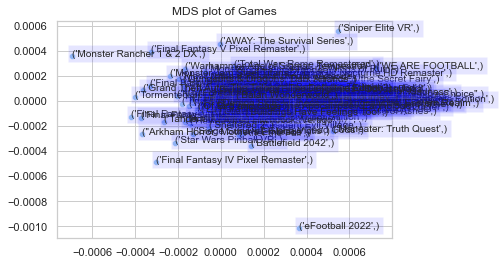

In [78]:
sns.scatterplot(xs,ys)
for i,game in enumerate(dist2.columns.values):
    plt.text(s=game, x= xs[i] , y=ys[i], bbox=dict(facecolor="blue",alpha=0.1))
plt.title('MDS plot of Games')
#plt.savefig('MDSplot.png')
plt.show()

In [79]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e', 5:"#1e25a6"}

#set up cluster names using a dict
cluster_names = {0: 'C1', 
                 1: 'C2', 
                 2: 'C3', 
                 3: 'C4', 
                 4: 'C5',
                 5: "C6"}

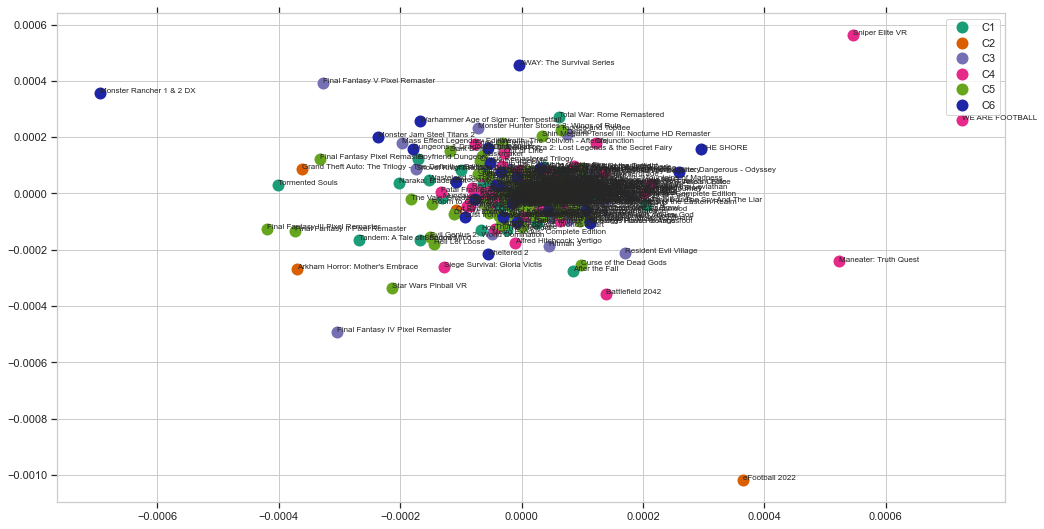

<Figure size 432x288 with 0 Axes>

In [80]:
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=gamenames)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the game title
for i in range(len(df)):
    ax.text(df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['title'], size=8)  

    
    
plt.show() #show the plot


plt.savefig('clusters_graph.png')

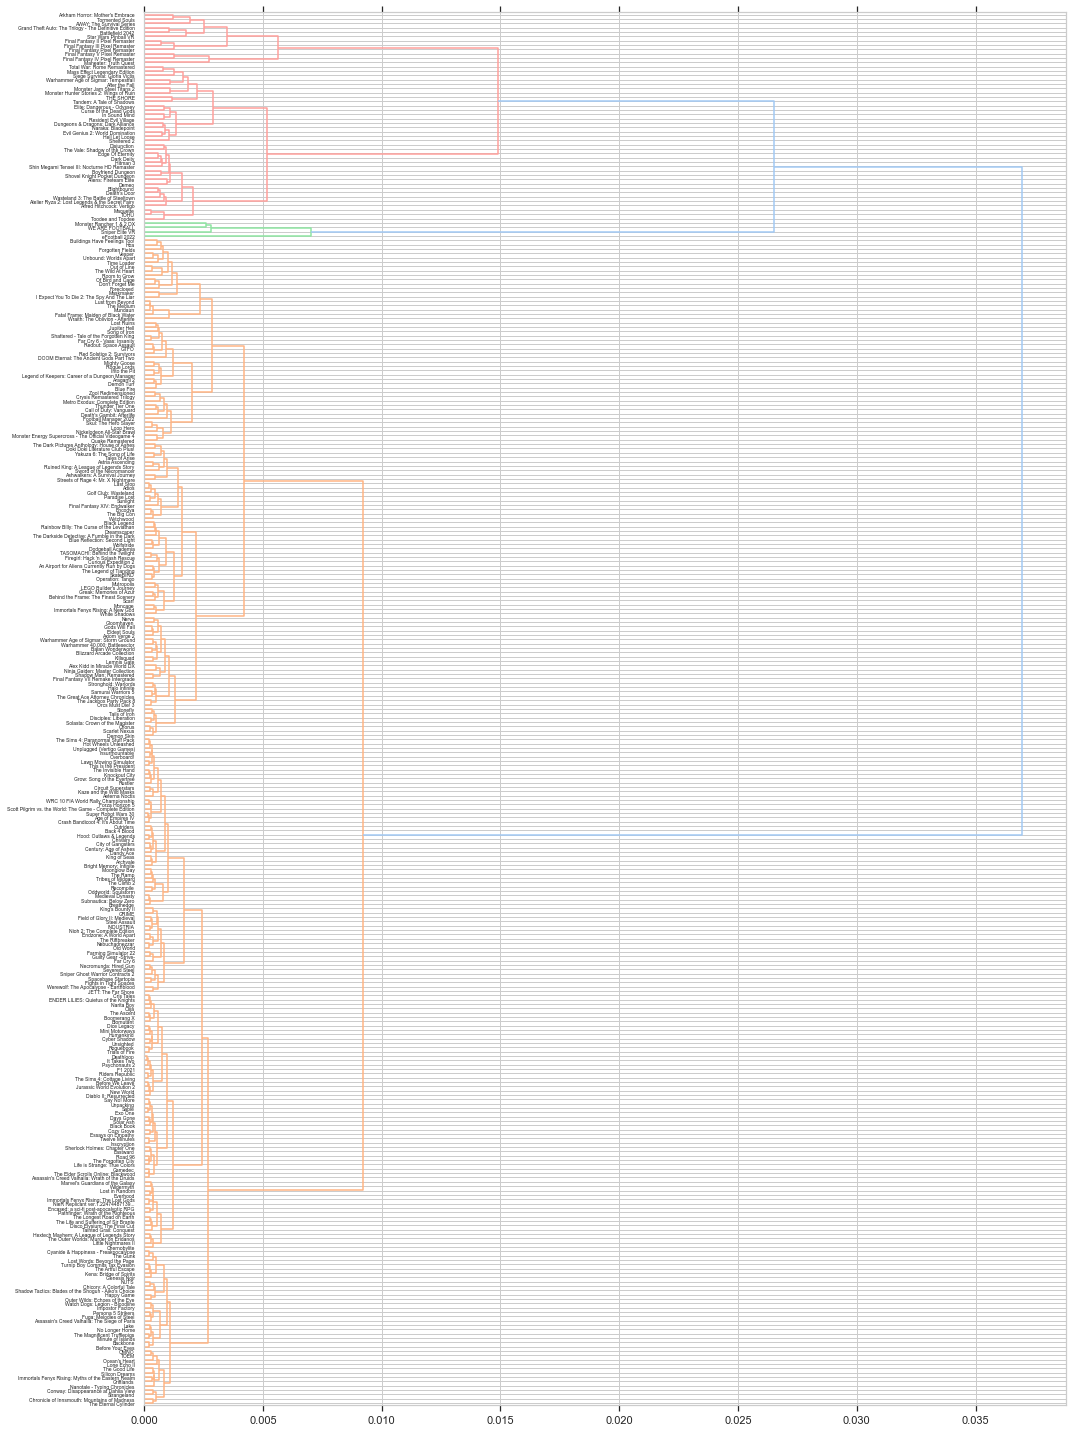

In [81]:
# Hierarchical document clustering
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist2) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=gamenames);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

## Using TFIDF Vectorizer with mean aggregation for clustering

In [82]:
# applying tfidf vectorizer to the lematized game reviews column
vec_words = TfidfVectorizer(decode_error='ignore',tokenizer=word_tokenize,stop_words='english',min_df=10, max_features=500)
vectors = vec_words.fit_transform(reviews['lemmatized'])

feature_names = vec_words.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
count = pd.DataFrame(denselist, columns=feature_names)

In [83]:
# looking at column names
column_names = count.columns
list(column_names)

['2',
 '2021',
 '2042',
 '3',
 '4',
 '5',
 '6',
 'ability',
 'able',
 'absolutely',
 'accessible',
 'action',
 'actually',
 'add',
 'addictive',
 'addition',
 'adventure',
 'aesthetic',
 'age',
 'ai',
 'amazing',
 'ambitious',
 'animation',
 'apart',
 'appeal',
 'approach',
 'area',
 'art',
 'artistic',
 'ascent',
 'aside',
 'aspect',
 'atmosphere',
 'attempt',
 'attention',
 'audience',
 'available',
 'away',
 'bad',
 'balance',
 'base',
 'battle',
 'battlefield',
 'beautiful',
 'best',
 'better',
 'big',
 'biomutant',
 'bit',
 'blend',
 'blood',
 'boring',
 'brilliant',
 'bring',
 'brings',
 'bug',
 'build',
 'building',
 'campaign',
 'card',
 'case',
 'cast',
 'certain',
 'certainly',
 'challenge',
 'challenging',
 'chance',
 'change',
 'chapter',
 'character',
 'charm',
 'charming',
 'chernobylite',
 'choice',
 'city',
 'classic',
 'clear',
 'clearly',
 'clever',
 'collection',
 'combat',
 'come',
 'coming',
 'compelling',
 'complete',
 'completely',
 'complex',
 'concept',
 'conte

In [84]:
# dropping the first 7 and last 6 columns as they are not words
count=count.iloc[:,7:-6]
list(count.columns)

['ability',
 'able',
 'absolutely',
 'accessible',
 'action',
 'actually',
 'add',
 'addictive',
 'addition',
 'adventure',
 'aesthetic',
 'age',
 'ai',
 'amazing',
 'ambitious',
 'animation',
 'apart',
 'appeal',
 'approach',
 'area',
 'art',
 'artistic',
 'ascent',
 'aside',
 'aspect',
 'atmosphere',
 'attempt',
 'attention',
 'audience',
 'available',
 'away',
 'bad',
 'balance',
 'base',
 'battle',
 'battlefield',
 'beautiful',
 'best',
 'better',
 'big',
 'biomutant',
 'bit',
 'blend',
 'blood',
 'boring',
 'brilliant',
 'bring',
 'brings',
 'bug',
 'build',
 'building',
 'campaign',
 'card',
 'case',
 'cast',
 'certain',
 'certainly',
 'challenge',
 'challenging',
 'chance',
 'change',
 'chapter',
 'character',
 'charm',
 'charming',
 'chernobylite',
 'choice',
 'city',
 'classic',
 'clear',
 'clearly',
 'clever',
 'collection',
 'combat',
 'come',
 'coming',
 'compelling',
 'complete',
 'completely',
 'complex',
 'concept',
 'content',
 'control',
 'cool',
 'coop',
 'core',
 'co

In [85]:
# joining the game reviews df with the tfidf vectorized attributes
final_df = reviews.join(count)
final_df.head()

,game_id,game_name,score,author,date,summary,tokenised,lemmatized,sentiment_label,sentiment_value,...,welcome,wish,wo,wonderful,work,world,worth,worthy,writing,year
0,0,Disco Elysium: The Final Cut,100,GameGrin,"Oct 15, 2021",Traversing the mind of your character is as mu...,"[Traversing, mind, character, much, plot, case...",Traversing mind character much plot case ’ try...,negative,-0.2960,...,0.000000,0.0,0.0,0.0,0.0,0.222848,0.0,0.0,0.0,0.000000
1,0,Disco Elysium: The Final Cut,100,Shindig,"Jun 18, 2021",Disco Elysium – The Final Cut is something rar...,"[Disco, Elysium, –, The, Final, Cut, something...",Disco Elysium – The Final Cut something rare ...,positive,0.9142,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
2,0,Disco Elysium: The Final Cut,100,KeenGamer,"Apr 26, 2021","Enhanced with fantastic and fresh content, Dis...","[Enhanced, fantastic, fresh, content, ,, Disco...",Enhanced fantastic fresh content Disco Elysiu...,positive,0.9423,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
3,0,Disco Elysium: The Final Cut,100,GameSpot,"Apr 15, 2021",A fully voiced cast and new content of compara...,"[A, fully, voiced, cast, new, content, compara...",A fully voiced cast new content comparable qua...,positive,0.8705,...,0.245121,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.175793
4,0,Disco Elysium: The Final Cut,100,Wccftech,"Apr 15, 2021",Disco Elysium: The Final Cut doesn't shy away ...,"[Disco, Elysium, :, The, Final, Cut, n't, shy,...",Disco Elysium The Final Cut nt shy away probl...,negative,-0.4731,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000


In [86]:
# identifying list of columns to keep
tokeep=list(attributes.colnames)
tokeep

['game_id',
 'game_name',
 'score',
 'author',
 'date',
 'summary',
 'tokenised',
 'lemmatized',
 'sentiment_label',
 'sentiment_value',
 'action',
 'adventure',
 'aesthetic',
 'ai',
 'ambitious',
 'appeal',
 'art',
 'atmosphere',
 'attention',
 'balance',
 'battle',
 'battlefield',
 'beautiful',
 'brilliant',
 'build',
 'building',
 'campaign',
 'challenge',
 'challenging',
 'character',
 'charm',
 'charming',
 'classic',
 'combat',
 'compelling',
 'complex',
 'dark',
 'dead',
 'death',
 'design',
 'detail',
 'developer',
 'development',
 'dialogue',
 'difficult',
 'difficulty',
 'dungeon',
 'edge',
 'edition',
 'effect',
 'element',
 'elite',
 'enemy',
 'engaging',
 'entertaining',
 'environment',
 'evil',
 'experience',
 'exploration',
 'explore',
 'fantasy',
 'feature',
 'feel',
 'feeling',
 'fight',
 'football',
 'franchise',
 'fresh',
 'fun',
 'gameplay',
 'gorgeous',
 'graphic',
 'hero',
 'history',
 'hit',
 'hitman',
 'horror',
 'indie',
 'interactive',
 'journey',
 'mission',


In [87]:
# identifying current list of columns
cols=list(final_df.columns)
cols

['game_id',
 'game_name',
 'score',
 'author',
 'date',
 'summary',
 'tokenised',
 'lemmatized',
 'sentiment_label',
 'sentiment_value',
 'ability',
 'able',
 'absolutely',
 'accessible',
 'action',
 'actually',
 'add',
 'addictive',
 'addition',
 'adventure',
 'aesthetic',
 'age',
 'ai',
 'amazing',
 'ambitious',
 'animation',
 'apart',
 'appeal',
 'approach',
 'area',
 'art',
 'artistic',
 'ascent',
 'aside',
 'aspect',
 'atmosphere',
 'attempt',
 'attention',
 'audience',
 'available',
 'away',
 'bad',
 'balance',
 'base',
 'battle',
 'battlefield',
 'beautiful',
 'best',
 'better',
 'big',
 'biomutant',
 'bit',
 'blend',
 'blood',
 'boring',
 'brilliant',
 'bring',
 'brings',
 'bug',
 'build',
 'building',
 'campaign',
 'card',
 'case',
 'cast',
 'certain',
 'certainly',
 'challenge',
 'challenging',
 'chance',
 'change',
 'chapter',
 'character',
 'charm',
 'charming',
 'chernobylite',
 'choice',
 'city',
 'classic',
 'clear',
 'clearly',
 'clever',
 'collection',
 'combat',
 'com

In [88]:
# removing the column names that aren't part of the list of columns to keep
for i in cols:
    if i not in tokeep:
        final_df.drop(columns=[i], inplace=True)

In [89]:
final_df.columns

Index(['game_id', 'game_name', 'score', 'author', 'date', 'summary',
       'tokenised', 'lemmatized', 'sentiment_label', 'sentiment_value',
       ...
       'universe', 'update', 'variety', 'version', 'visual', 'visuals', 'vr',
       'war', 'weapon', 'writing'],
      dtype='object', length=128)

In [90]:
# df with just the attribute, metascore, and sentiment
final_df2=final_df.drop(columns=["game_name","author","date","summary","tokenised","lemmatized","sentiment_label"])

In [91]:
# aggregate values of each attribute column by the sum for each video game
final_df3=final_df2.groupby("game_id").mean()
final_df3

,score,sentiment_value,action,adventure,aesthetic,ai,ambitious,appeal,art,atmosphere,...,universe,update,variety,version,visual,visuals,vr,war,weapon,writing
game_id,,,,,,,,,,,,,,,,,,,,,
0,97.272727,0.531809,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.029563,0.000000,...,0.000000,0.067074,0.000000,0.052928,0.000000,0.000000,0.0,0.0,0.0,0.000000
1,91.962963,0.790196,0.000000,0.022119,0.000000,0.000000,0.021302,0.000000,0.000000,0.000000,...,0.008209,0.000000,0.000000,0.000000,0.013431,0.000000,0.0,0.0,0.0,0.000000
2,91.100000,0.777425,0.019107,0.026320,0.000000,0.013441,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.013205,0.021369,0.000000,0.015961,0.011420,0.0,0.0,0.0,0.000000
3,89.782609,0.737909,0.000000,0.080109,0.012196,0.000000,0.009001,0.013853,0.015774,0.000000,...,0.021563,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
4,88.970588,0.745638,0.007705,0.044341,0.000000,0.000000,0.000000,0.012479,0.006378,0.000000,...,0.028370,0.000000,0.000000,0.000000,0.017149,0.010352,0.0,0.0,0.0,0.016985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,48.800000,0.250970,0.000000,0.000000,0.000000,0.025279,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
317,48.428571,-0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068165,...,0.051671,0.000000,0.000000,0.070561,0.000000,0.000000,0.0,0.0,0.0,0.000000
318,43.846154,0.304862,0.000000,0.000000,0.000000,0.000000,0.017141,0.020453,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.018576,0.015665,0.0,0.0,0.0,0.017010


In [92]:
# applying cosine similiarty
from sklearn.metrics.pairwise import cosine_similarity
dist=1-cosine_similarity(final_df3)
dist

array([[ 0.00000000e+00,  1.02152779e-05,  7.94926764e-06, ...,
         7.35090843e-06,  7.43794103e-06,  1.27719133e-04],
       [ 1.02152779e-05,  2.22044605e-16,  4.41292736e-06, ...,
         8.10481901e-06,  1.57040339e-05,  1.72163149e-04],
       [ 7.94926764e-06,  4.41292736e-06,  0.00000000e+00, ...,
         7.91101691e-06,  1.31095843e-05,  1.65133082e-04],
       ...,
       [ 7.35090843e-06,  8.10481901e-06,  7.91101691e-06, ...,
        -4.44089210e-16,  1.07438408e-05,  1.51645290e-04],
       [ 7.43794103e-06,  1.57040339e-05,  1.31095843e-05, ...,
         1.07438408e-05,  2.22044605e-16,  1.24870176e-04],
       [ 1.27719133e-04,  1.72163149e-04,  1.65133082e-04, ...,
         1.51645290e-04,  1.24870176e-04,  1.11022302e-16]])

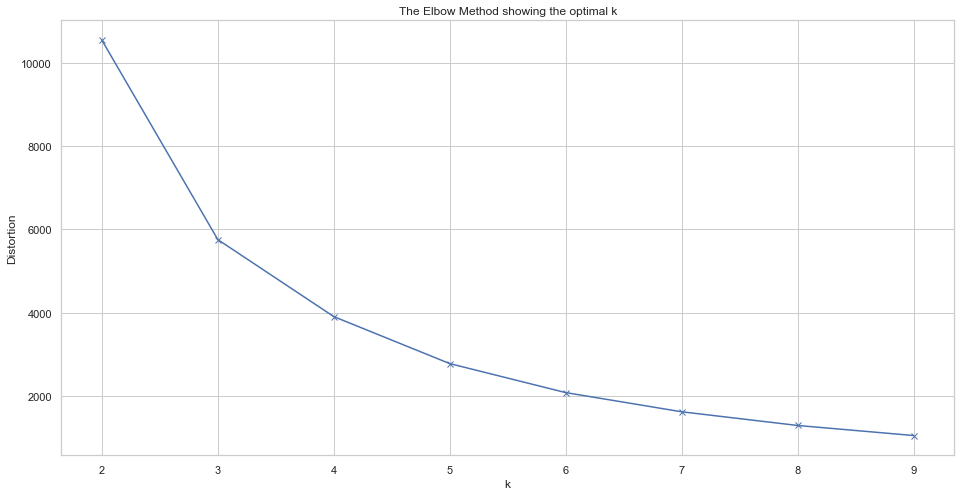

In [93]:
# using elbow method to determine number of clusters 
from sklearn.cluster import KMeans
vals = []
for i in range(2,10):
    kmeans=KMeans(n_clusters=i)
    model = kmeans.fit(final_df6)
    vals.append(model.inertia_)
K=range(2,10)
plt.figure(figsize=(16,8))
plt.plot(K, vals, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [94]:
# k-means clustering with 6 clusters
from sklearn.cluster import KMeans
num_clusters = 6
km = KMeans(n_clusters=num_clusters)
km.fit(final_df3)
clusters = km.labels_.tolist()

In [95]:
import joblib
joblib.dump(km,  'doc_cluster.pkl')

km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [96]:
# creating dataframe for clusters
dictionary={"clusters":clusters}
clusts=pd.DataFrame(dictionary)
clusts.head()

,clusters
0,3
1,3
2,3
3,3
4,3


In [97]:
# joining the clusters to the grouped tfidf file
games=final_df3.join(clusts)
games.head()

,score,sentiment_value,action,adventure,aesthetic,ai,ambitious,appeal,art,atmosphere,...,update,variety,version,visual,visuals,vr,war,weapon,writing,clusters
game_id,,,,,,,,,,,,,,,,,,,,,
0,97.272727,0.531809,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.029563,0.0,...,0.067074,0.000000,0.052928,0.000000,0.000000,0.0,0.0,0.0,0.000000,3
1,91.962963,0.790196,0.000000,0.022119,0.000000,0.000000,0.021302,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.013431,0.000000,0.0,0.0,0.0,0.000000,3
2,91.100000,0.777425,0.019107,0.026320,0.000000,0.013441,0.000000,0.000000,0.000000,0.0,...,0.013205,0.021369,0.000000,0.015961,0.011420,0.0,0.0,0.0,0.000000,3
3,89.782609,0.737909,0.000000,0.080109,0.012196,0.000000,0.009001,0.013853,0.015774,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,3
4,88.970588,0.745638,0.007705,0.044341,0.000000,0.000000,0.000000,0.012479,0.006378,0.0,...,0.000000,0.000000,0.000000,0.017149,0.010352,0.0,0.0,0.0,0.016985,3


In [98]:
# seeing how many games are in each cluster
games["clusters"].value_counts()

1    93
4    81
3    59
0    56
5    26
2     6
Name: clusters, dtype: int64

In [99]:
# average metascore per cluster
grouped=games["score"].groupby(games["clusters"])

grouped.mean()

clusters
0    67.523348
1    78.838648
2    42.383666
3    84.661867
4    73.265849
5    59.036255
Name: score, dtype: float64

In [100]:
# average sentiment per cluster
grouped=games["sentiment_value"].groupby(games["clusters"])

grouped.mean()

clusters
0    0.462283
1    0.599499
2    0.067719
3    0.644532
4    0.502515
5    0.349492
Name: sentiment_value, dtype: float64

In [101]:
# selecting only the attributes columns
attributes2=attributes.iloc[10:,:]
attributes2

,colnames
10,action
11,adventure
12,aesthetic
13,ai
14,ambitious
...,...
124,visuals
125,vr
126,war
127,weapon


In [102]:
# identifying the closest attributes to each cluster centroid
# code taken from : https://stackoverflow.com/questions/47452119/kmean-clustering-top-terms-in-cluster
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d:" % i, end='\n')
    for ind in order_centroids[i, :10]:
        print(' %s' % attributes2.colnames.tolist()[ind], end='')
        print()

Top terms per cluster:
Cluster 0:
 action
 adventure
 gameplay
 storytelling
 gorgeous
 exploration
 feeling
 ai
 complex
 quality
Cluster 1:
 action
 adventure
 exploration
 storytelling
 gameplay
 gorgeous
 feeling
 complex
 ai
 charming
Cluster 2:
 action
 adventure
 indie
 twist
 franchise
 effect
 shooter
 complex
 gorgeous
 variety
Cluster 3:
 action
 adventure
 shooter
 storytelling
 exploration
 ai
 gorgeous
 charming
 gameplay
 feature
Cluster 4:
 action
 adventure
 exploration
 storytelling
 gorgeous
 gameplay
 ai
 feeling
 quality
 charming
Cluster 5:
 action
 adventure
 multiplayer
 gorgeous
 exploration
 storytelling
 ai
 theme
 gameplay
 complex


In [103]:
gamenames=list(final_df.game_name.unique())

In [104]:
# converting numpy array of similarity into dataframe
dist2=pd.DataFrame(dist)
dist2=dist2.set_axis([gamenames], axis=1)
dist2=dist2.set_axis([gamenames], axis="index")
dist2

,Disco Elysium: The Final Cut,Final Fantasy XIV: Endwalker,Forza Horizon 5,Chicory: A Colorful Tale,Psychonauts 2,Streets of Rage 4: Mr. X Nightmare,It Takes Two,Hitman 3,Wildermyth,Final Fantasy VII Remake Intergrade,...,Foreclosed,Buildings Have Feelings Too!,Dungeons & Dragons: Dark Alliance,AWAY: The Survival Series,Grand Theft Auto: The Trilogy - The Definitive Edition,Demon Skin,Arkham Horror: Mother's Embrace,Of Bird and Cage,Balan Wonderworld,eFootball 2022
Disco Elysium: The Final Cut,0.000000,1.021528e-05,0.000008,8.747232e-06,7.381567e-06,0.000006,0.000007,0.000018,0.000007,0.000005,...,0.000013,0.000019,0.000022,0.000032,0.000031,5.170919e-06,8.967081e-05,7.350908e-06,7.437941e-06,1.277191e-04
Final Fantasy XIV: Endwalker,0.000010,2.220446e-16,0.000004,4.987164e-06,4.449802e-06,0.000009,0.000004,0.000016,0.000004,0.000006,...,0.000027,0.000017,0.000039,0.000030,0.000053,1.137459e-05,1.306226e-04,8.104819e-06,1.570403e-05,1.721631e-04
Forza Horizon 5,0.000008,4.412927e-06,0.000000,3.831904e-06,2.004170e-06,0.000007,0.000002,0.000013,0.000004,0.000007,...,0.000024,0.000015,0.000036,0.000024,0.000049,9.830551e-06,1.275740e-04,7.911017e-06,1.310958e-05,1.651331e-04
Chicory: A Colorful Tale,0.000009,4.987164e-06,0.000004,-2.220446e-16,3.640107e-06,0.000008,0.000002,0.000016,0.000005,0.000009,...,0.000023,0.000014,0.000037,0.000029,0.000049,1.036419e-05,1.253056e-04,8.571844e-06,1.294846e-05,1.672798e-04
Psychonauts 2,0.000007,4.449802e-06,0.000002,3.640107e-06,-4.440892e-16,0.000006,0.000002,0.000014,0.000004,0.000007,...,0.000023,0.000015,0.000036,0.000028,0.000049,9.068124e-06,1.255592e-04,7.230732e-06,1.212960e-05,1.666238e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Demon Skin,0.000005,1.137459e-05,0.000010,1.036419e-05,9.068124e-06,0.000008,0.000009,0.000020,0.000010,0.000006,...,0.000012,0.000020,0.000018,0.000034,0.000032,5.551115e-16,8.732114e-05,8.784555e-06,7.246622e-06,1.272409e-04
Arkham Horror: Mother's Embrace,0.000090,1.306226e-04,0.000128,1.253056e-04,1.255592e-04,0.000108,0.000128,0.000135,0.000125,0.000098,...,0.000071,0.000132,0.000070,0.000144,0.000074,8.732114e-05,1.110223e-16,1.104196e-04,8.713070e-05,9.393531e-05
Of Bird and Cage,0.000007,8.104819e-06,0.000008,8.571844e-06,7.230732e-06,0.000009,0.000007,0.000018,0.000007,0.000009,...,0.000018,0.000018,0.000029,0.000033,0.000044,8.784555e-06,1.104196e-04,-4.440892e-16,1.074384e-05,1.516453e-04
Balan Wonderworld,0.000007,1.570403e-05,0.000013,1.294846e-05,1.212960e-05,0.000011,0.000013,0.000023,0.000013,0.000009,...,0.000014,0.000018,0.000022,0.000037,0.000031,7.246622e-06,8.713070e-05,1.074384e-05,2.220446e-16,1.248702e-04


In [105]:
# MDS plot for similarity
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist2) 
xs,ys = pos.T

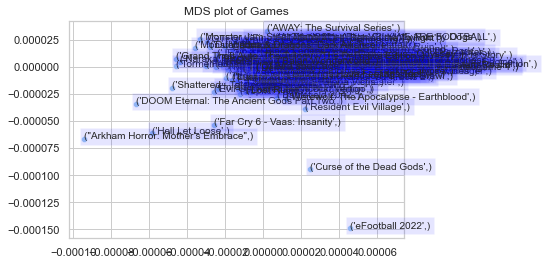

In [106]:
sns.scatterplot(xs,ys)
for i,game in enumerate(dist2.columns.values):
    plt.text(s=game, x= xs[i], y=ys[i], bbox=dict(facecolor="blue",alpha=0.1))
plt.title('MDS plot of Games')
#plt.savefig('MDSplot.png')
plt.show()

In [107]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e', 5:"#1e25a6"}

#set up cluster names using a dict
cluster_names = {0: 'C1', 
                 1: 'C2', 
                 2: 'C3', 
                 3: 'C4', 
                 4: 'C5',
                 5: "C6"}

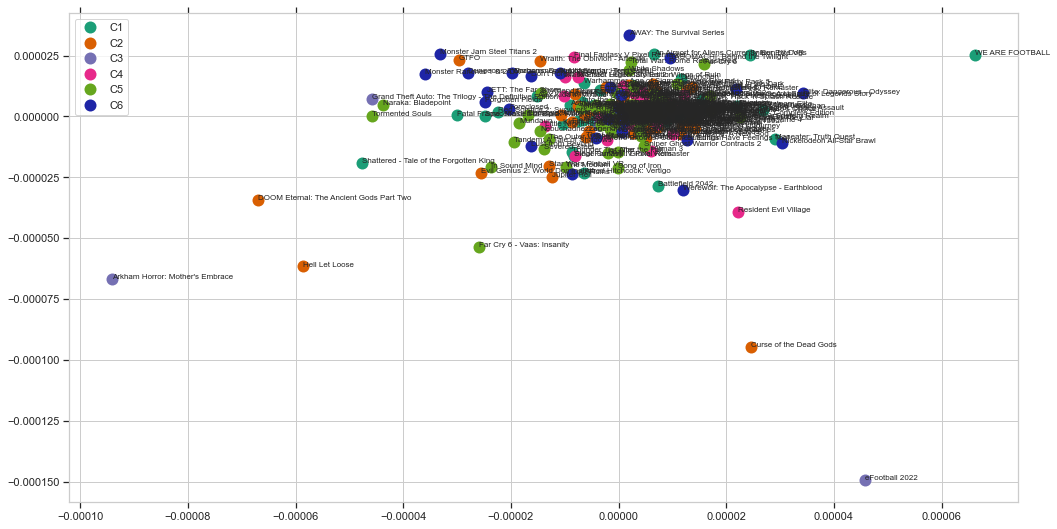

<Figure size 432x288 with 0 Axes>

In [108]:
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=gamenames)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the game title
for i in range(len(df)):
    ax.text(df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['title'], size=8)  

    
    
plt.show() #show the plot


plt.savefig('clusters_graph.png')

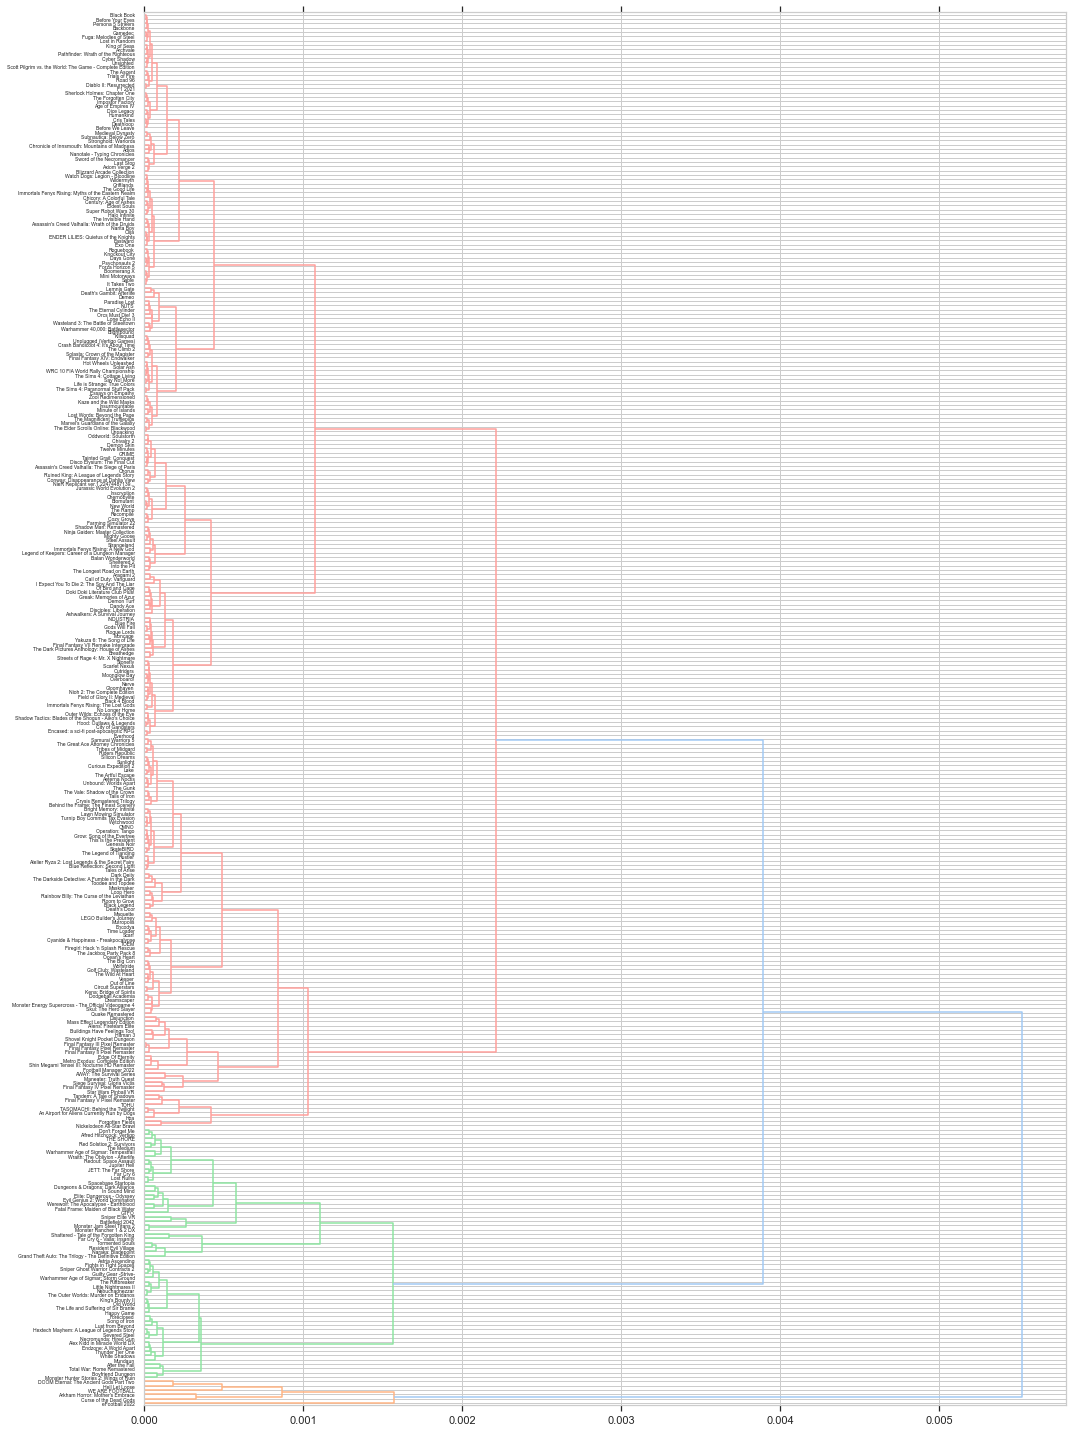

In [109]:
# Hierarchical document clustering
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist2) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=gamenames);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters